In [36]:
import numpy as np
import os
import csv
from scipy.stats import poisson
from scipy.stats import norm
import pandas as pd
import itertools
import matplotlib.pyplot as plot

In [2]:
def EstimateParameters(fixture_list_1, fixture_list_2, fixture_list_3,
                       teams, beta, thetapriormeans, thetapriorsds,
                       niter=1000, log=False, temp=0, zerooutinds=np.array([])):
    
    # xdata and ydata are coordinates and y values of data
    # xmodel are coordinates of model evaluations
    # thetaprior are prior guesses for parameters
    
    # draw initial
    if log:
        if hasattr(thetapriormeans, '__len__'):
            theta = np.zeros(len(thetapriormeans))
            for i in range(len(thetapriormeans)):
                theta[i] = np.exp(np.random.normal(thetapriormeans[i], thetapriorsds[i], 1))
        else:
            theta = np.exp(np.random.normal(thetapriormeans, thetapriorsds, 1))
    else:
        if hasattr(thetapriormeans, '__len__'):
            theta = np.zeros(len(thetapriormeans))
            for i in range(len(thetapriormeans)):
                theta[i] = np.random.normal(thetapriormeans[i], thetapriorsds[i], 1)
            # normalize
            #theta[(len(teams) + 1 - 1)] = -np.sum(theta[1:(len(teams) + 1 - 1)])
            #theta[((2 * len(teams)) + 1 - 1)] = -np.sum(theta[(len(teams) + 1):((2 * len(teams)) + 1 - 1)])
        else:
            theta = np.random.normal(thetapriormeans, thetapriorsds, 1)
    
    if hasattr(thetapriormeans, '__len__'):
        thetaarray = np.zeros((niter, len(thetapriormeans)))
    else:
        thetaarray = np.zeros(niter)
        
    accept_count = 0
    
    for j in range(niter):
        
        # temperature
        T = np.exp(-temp * ((i + 1) / niter))
        
        if log:
            if hasattr(thetapriormeans, '__len__'):
                thetastar = np.exp(np.log(theta) + np.random.normal(0, np.sqrt(beta), len(theta)))
            else:
                thetastar = np.exp(np.log(theta) + np.random.normal(0, np.sqrt(beta), 1))
        else:
            if hasattr(thetapriormeans, '__len__'):
                ind = np.random.normal(0, np.sqrt(beta), len(theta))
                # normalize
                #ind[(len(teams) + 1 - 1)] = -np.sum(ind[1:(len(teams) + 1 - 1)])
                #ind[((2 * len(teams)) + 1 - 1)] = -np.sum(ind[(len(teams) + 1):((2 * len(teams)) + 1 - 1)])
                thetastar = theta + ind
            else:
                ind = np.random.normal(0, np.sqrt(beta), 1)
                thetastar = theta + ind
        
        # get likelihood for each
        mu = theta[0]
        a = theta[1:(len(teams) + 1)]
        d = theta[(len(teams) + 1):((2 * len(teams)) + 1)]
        if len(zerooutinds) > 0:  # promoted team zero out
            a[zerooutinds] = 0
            d[zerooutinds] = 0
        a[0] = - np.sum(a[1:])  # normalize
        d[0] = - np.sum(d[1:])  # normalize
        alpha = theta[((2 * len(teams)) + 1)]
        Htheta = likelihood_three_seasons(fixture_list_1, fixture_list_2, fixture_list_3,
                                          teams, mu, a, d, alpha)
        
        mu = thetastar[0]
        a = thetastar[1:(len(teams) + 1)]
        d = thetastar[(len(teams) + 1):((2 * len(teams)) + 1)]
        if len(zerooutinds) > 0:  # promoted team zero out
            a[zerooutinds] = 0
            d[zerooutinds] = 0
        a[0] = - np.sum(a[1:])  # normalize
        d[0] = - np.sum(d[1:])  # normalize
        alpha = thetastar[((2 * len(teams)) + 1)]
        Hthetastar = likelihood_three_seasons(fixture_list_1, fixture_list_2, fixture_list_3,
                                              teams, mu, a, d, alpha)
        
        alpha = np.min([0, (1 / T) * (Hthetastar - Htheta)])
        
        # sample uniformly
        u = np.random.uniform(0, 1)
        
        # accept or not
        accept = np.log(u) <= alpha
        
        if accept:
            theta = thetastar
            accept_count += 1
            
        if hasattr(thetapriormeans, '__len__'):
            thetaarray[j, :] = theta
            if (j%10) == 0:
                print('------')
                print('Iteration: ', str(j))
                print('Home coefficient: '+str(thetaarray[j, 0]))
                print('Arsenal attack coefficient: '+str(thetaarray[j, 1]))
                print('acceptance ratio: ', accept_count / (j + 1))
        else:
            thetaarray[j] = theta
    
    # convert back and normalize
    if hasattr(thetapriormeans, '__len__'):
        if len(zerooutinds) > 0:  # zero out promoted teams
            thetaarray[:, (1 + zerooutinds).astype(int)] = 0.
            thetaarray[:, (1 + zerooutinds + len(teams)).astype(int)] = 0.
        thetaarray[:, 1] = - np.sum(thetaarray[:, 2:(len(teams) + 1)], axis=1)
        thetaarray[:, (len(teams) + 1)] = - np.sum(thetaarray[:, (len(teams) + 2):((2 * len(teams)) + 1)], axis=1)
    
    return thetaarray

# create likelihood eval for one game
def likelihood_one_game(goals_ht, goals_at, form_ht, form_at, mu, a_ht, d_ht, a_at, d_at, alpha):
    lambda_ht = np.exp(mu + a_ht + d_at + (alpha * form_ht))
    lambda_at = np.exp(a_at + d_ht + (alpha * form_at))
    p1 = poisson.pmf(goals_ht, lambda_ht)
    p2 = poisson.pmf(goals_at, lambda_at)
    return(p1 * p2)

# create likelihood eval for single season
def likelihood_season(fixtures_list, teams, mu, a, d, alpha):
    N = np.shape(fixtures_list)[0]
    goals_ht = fixtures_list[:, 2]
    goals_at = fixtures_list[:, 3]
    teams_ht = fixtures_list[:, 0]
    teams_at = fixtures_list[:, 1]
    
    teams_for_season = np.unique(teams_ht)
    
    points = np.zeros((38, 20))
    team_count = np.zeros(20)
    for i in range(N):
        points[team_count[np.where(teams_for_season == teams_ht[i])[0][0].astype(int)].astype(int), np.where(teams_for_season == teams_ht[i])[0][0].astype(int)] = (3 * (goals_ht[i] > goals_at[i])) + (goals_ht[i] == goals_at[i])
        points[team_count[np.where(teams_for_season == teams_at[i])[0][0].astype(int)].astype(int), np.where(teams_for_season == teams_at[i])[0][0].astype(int)] = (3 * (goals_ht[i] < goals_at[i])) + (goals_ht[i] == goals_at[i])
        team_count[np.where(teams_for_season == teams_ht[i])[0][0].astype(int)] += 1
        team_count[np.where(teams_for_season == teams_at[i])[0][0].astype(int)] += 1
    form = np.ones((38, 20)) * 7.5
    for j in range(20):
        form[5:, j] = np.cumsum(points[:, j])[5:] - np.cumsum(points[:, j])[:(38 - 5)]
    
    team_count = np.zeros(20)
    likelihood = np.zeros(N)
    for i in range(N):
        ind_ht = np.where(teams == teams_ht[i])[0][0].astype(int)
        ind_at = np.where(teams == teams_at[i])[0][0].astype(int)
        ind_for_season_ht = np.where(teams_for_season == teams_ht[i])[0][0].astype(int)
        ind_for_season_at = np.where(teams_for_season == teams_at[i])[0][0].astype(int)
        l = likelihood_one_game(goals_ht[i], goals_at[i],
                                form[team_count[ind_for_season_ht].astype(int), ind_for_season_ht].astype(int), form[team_count[ind_for_season_at].astype(int), ind_for_season_at],
                                mu, a[ind_ht], d[ind_ht], a[ind_at], d[ind_at], alpha)
        team_count[np.where(teams_for_season == teams_ht[i])[0][0].astype(int)] += 1
        team_count[np.where(teams_for_season == teams_at[i])[0][0].astype(int)] += 1
        likelihood[i] = l
    
    return(np.sum(np.log(likelihood)))

# likelihood over three seasons - weighted
def likelihood_three_seasons(fixture_list_1, fixture_list_2, fixture_list_3, teams, mu, a, d, alpha):
    likelihood = (0.2 * likelihood_season(fixture_list_1, teams, mu, a, d, alpha)) + (0.3 * likelihood_season(fixture_list_2, teams, mu, a, d, alpha)) + (0.5 * likelihood_season(fixture_list_3, teams, mu, a, d, alpha))
    return(likelihood)

# function to predict probabilities of fixtures
def predict_fixtures(new_fixtures, form, teams, mu, a, d, alpha, uncertainty=False):
    if uncertainty:
        # form is N x 2
        N = np.shape(new_fixtures)[0]
        teams_ht = new_fixtures[:, 0]
        teams_at = new_fixtures[:, 1]
        lambda_1 = np.zeros(N)
        lambda_2 = np.zeros(N)
        for i in range(N):
            muest = np.random.normal(mu[0], mu[1])
            aest = np.zeros(len(teams))
            dest = np.zeros(len(teams))
            for u in range(len(teams)):
                aest[u] = np.random.normal(a[u, 0], a[u, 1])
                dest[u] = np.random.normal(d[u, 0], d[u, 1])
            alphaest = np.random.normal(alpha[0], alpha[1])
            ind_ht = np.where(teams == teams_ht[i])[0][0].astype(int)
            ind_at = np.where(teams == teams_at[i])[0][0].astype(int)
            lambda_1[i] = np.exp(muest + aest[ind_ht] + dest[ind_at] + (alphaest * form[i, 0]))
            lambda_2[i] = np.exp(aest[ind_at] + dest[ind_ht] + (alphaest * form[i, 1]))
    else:
        # form is N x 2
        N = np.shape(new_fixtures)[0]
        teams_ht = new_fixtures[:, 0]
        teams_at = new_fixtures[:, 1]
        lambda_1 = np.zeros(N)
        lambda_2 = np.zeros(N)
        for i in range(N):
            ind_ht = np.where(teams == teams_ht[i])[0][0].astype(int)
            ind_at = np.where(teams == teams_at[i])[0][0].astype(int)
            lambda_1[i] = np.exp(mu + a[ind_ht] + d[ind_at] + (alpha * form[i, 0]))
            lambda_2[i] = np.exp(a[ind_at] + d[ind_ht] + (alpha * form[i, 1]))
    return(lambda_1, lambda_2)

def import_fixture_lists(filename_1, filename_2, filename_3):
    fixture_list_1 = pd.read_csv(filename_1, header=None)
    fixture_list_2 = pd.read_csv(filename_2, header=None)
    fixture_list_3 = pd.read_csv(filename_3, header=None)
    return(fixture_list_1, fixture_list_2, fixture_list_3)

def import_fixture_list(filename):
    fixture_list = pd.read_csv(filename, header=None)
    return(fixture_list)

In [3]:
fixture_list_1, fixture_list_2, fixture_list_3 = import_fixture_lists("prem_results_20162017.csv",
                                                                      "prem_results_20172018.csv",
                                                                      "prem_results_20182019.csv")

In [4]:
# all teams in three seasons and fourth season
team_list = np.concatenate((np.unique(fixture_list_1.as_matrix()[:, 0]),
                            np.unique(fixture_list_2.as_matrix()[:, 0]),
                            np.unique(fixture_list_3.as_matrix()[:, 0]),
                            ((pd.read_csv("teams_20192020.csv", header=None)).as_matrix())[:, 0]))

c:\users\alsgregory\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
c:\users\alsgregory\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
c:\users\alsgregory\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.
c:\users\alsgregory\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


In [5]:
teams = np.unique(team_list)

In [6]:
fl1 = fixture_list_1.as_matrix()
fl2 = fixture_list_2.as_matrix()
fl3 = fixture_list_3.as_matrix()

c:\users\alsgregory\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
c:\users\alsgregory\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
c:\users\alsgregory\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
# test
a = np.ones(len(teams)) * 0.1
d = np.ones(len(teams)) * 0.1
mu = 0.1
alpha = 0.1
l = likelihood_season(fl1, teams, mu, a, d, alpha)

In [8]:
# test
predict_fixtures(fl1[1:3, :], np.array([[3, 3], [3, 3]]), teams, mu, a, d, alpha)

(array([1.8221188, 1.8221188]), array([1.64872127, 1.64872127]))

In [9]:
priormeans = np.ones((2 * len(teams)) + 2) * 0.0
priorsds = np.ones((2 * len(teams)) + 2) * 0.1
beta = 0.00025
niter = 50000

# prior-out promoted teams
inds = list(np.where(teams == 'Norwich City')[0])
inds.append(np.where(teams == 'Aston Villa')[0][0])
inds.append(np.where(teams == 'Sheffield United')[0][0])
inds = np.array(inds)

est = EstimateParameters(fl1, fl2, fl3, teams, beta, priormeans, priorsds, niter=niter, zerooutinds=inds)

------
Iteration:  0
Home coefficient: -0.216962178735096
Arsenal attack coefficient: 0.17488697406304277
acceptance ratio:  1.0
------
Iteration:  10
Home coefficient: -0.214228574708334
Arsenal attack coefficient: -0.08908678920792476
acceptance ratio:  0.6363636363636364
------
Iteration:  20
Home coefficient: -0.18565319631330485
Arsenal attack coefficient: 0.0003456324399933042
acceptance ratio:  0.47619047619047616
------
Iteration:  30
Home coefficient: -0.17897501597756607
Arsenal attack coefficient: 0.02846838835144623
acceptance ratio:  0.45161290322580644
------
Iteration:  40
Home coefficient: -0.1454534930105364
Arsenal attack coefficient: 0.030993600705516697
acceptance ratio:  0.3902439024390244
------
Iteration:  50
Home coefficient: -0.08424112993877317
Arsenal attack coefficient: -0.05191539227774163
acceptance ratio:  0.37254901960784315
------
Iteration:  60
Home coefficient: -0.10560788979254826
Arsenal attack coefficient: 0.016703929824338215
acceptance ratio:  0.

------
Iteration:  560
Home coefficient: 0.05251103719772764
Arsenal attack coefficient: 0.1725103024963952
acceptance ratio:  0.2014260249554367
------
Iteration:  570
Home coefficient: 0.031196708258201387
Arsenal attack coefficient: 0.2985073513461989
acceptance ratio:  0.2031523642732049
------
Iteration:  580
Home coefficient: 0.021245518514905897
Arsenal attack coefficient: 0.14708427039799882
acceptance ratio:  0.20309810671256454
------
Iteration:  590
Home coefficient: 0.021245518514905897
Arsenal attack coefficient: 0.14708427039799882
acceptance ratio:  0.1996615905245347
------
Iteration:  600
Home coefficient: 0.062069857147433974
Arsenal attack coefficient: 0.22652583982474267
acceptance ratio:  0.19966722129783693
------
Iteration:  610
Home coefficient: 0.07707603249035119
Arsenal attack coefficient: 0.10143811180431057
acceptance ratio:  0.19967266775777415
------
Iteration:  620
Home coefficient: 0.047528947363877125
Arsenal attack coefficient: 0.1014986023462759
acce

------
Iteration:  1120
Home coefficient: 0.19089965806810252
Arsenal attack coefficient: 0.3074553040384049
acceptance ratio:  0.19892952720785012
------
Iteration:  1130
Home coefficient: 0.14714595056804775
Arsenal attack coefficient: 0.3115652014460056
acceptance ratio:  0.19982316534040673
------
Iteration:  1140
Home coefficient: 0.1369545073113899
Arsenal attack coefficient: 0.29773492336610297
acceptance ratio:  0.19982471516213848
------
Iteration:  1150
Home coefficient: 0.15254983049435503
Arsenal attack coefficient: 0.3128020433719897
acceptance ratio:  0.1989574283231972
------
Iteration:  1160
Home coefficient: 0.15127249745699928
Arsenal attack coefficient: 0.25233585622892685
acceptance ratio:  0.19810508182601205
------
Iteration:  1170
Home coefficient: 0.15127249745699928
Arsenal attack coefficient: 0.25233585622892685
acceptance ratio:  0.1964133219470538
------
Iteration:  1180
Home coefficient: 0.15127249745699928
Arsenal attack coefficient: 0.25233585622892685
ac

------
Iteration:  1680
Home coefficient: 0.1070152303667895
Arsenal attack coefficient: 0.40448902501959993
acceptance ratio:  0.2016656751933373
------
Iteration:  1690
Home coefficient: 0.09817311251480731
Arsenal attack coefficient: 0.49720366647511055
acceptance ratio:  0.20224719101123595
------
Iteration:  1700
Home coefficient: 0.12392583076166595
Arsenal attack coefficient: 0.4369386600381371
acceptance ratio:  0.2022339800117578
------
Iteration:  1710
Home coefficient: 0.1385733617967696
Arsenal attack coefficient: 0.43541949729832086
acceptance ratio:  0.2016364699006429
------
Iteration:  1720
Home coefficient: 0.11862883434312316
Arsenal attack coefficient: 0.29707680896811844
acceptance ratio:  0.2010459035444509
------
Iteration:  1730
Home coefficient: 0.12265126906397027
Arsenal attack coefficient: 0.23304891289831314
acceptance ratio:  0.20161756210283074
------
Iteration:  1740
Home coefficient: 0.1280784774045315
Arsenal attack coefficient: 0.3483793390579712
accep

------
Iteration:  2240
Home coefficient: 0.1250035278659239
Arsenal attack coefficient: 0.40043155811896775
acceptance ratio:  0.18741633199464525
------
Iteration:  2250
Home coefficient: 0.10584591167214838
Arsenal attack coefficient: 0.35975049211737875
acceptance ratio:  0.18702798756108396
------
Iteration:  2260
Home coefficient: 0.09452982039456391
Arsenal attack coefficient: 0.3192007472723598
acceptance ratio:  0.18708536045997345
------
Iteration:  2270
Home coefficient: 0.09794503033203328
Arsenal attack coefficient: 0.40124354272348484
acceptance ratio:  0.18714222809335096
------
Iteration:  2280
Home coefficient: 0.13485364105622463
Arsenal attack coefficient: 0.27988399894636845
acceptance ratio:  0.18763700131521263
------
Iteration:  2290
Home coefficient: 0.11568351409222669
Arsenal attack coefficient: 0.39575312313171673
acceptance ratio:  0.18769096464426016
------
Iteration:  2300
Home coefficient: 0.10774660169965958
Arsenal attack coefficient: 0.2797264006337002

------
Iteration:  2800
Home coefficient: 0.2347557141156498
Arsenal attack coefficient: 0.4866169812226474
acceptance ratio:  0.18779007497322384
------
Iteration:  2810
Home coefficient: 0.2721369460303772
Arsenal attack coefficient: 0.41466476900275556
acceptance ratio:  0.18783351120597652
------
Iteration:  2820
Home coefficient: 0.24924378007570114
Arsenal attack coefficient: 0.2619852404283059
acceptance ratio:  0.18858560794044665
------
Iteration:  2830
Home coefficient: 0.20796762880534236
Arsenal attack coefficient: 0.4923919340290052
acceptance ratio:  0.18933239138113742
------
Iteration:  2840
Home coefficient: 0.23679234854403494
Arsenal attack coefficient: 0.6101535372259321
acceptance ratio:  0.18936994016191483
------
Iteration:  2850
Home coefficient: 0.22651193649685977
Arsenal attack coefficient: 0.5510769389494237
acceptance ratio:  0.1890564714135391
------
Iteration:  2860
Home coefficient: 0.1840450626942652
Arsenal attack coefficient: 0.3593160346252749
accept

------
Iteration:  3360
Home coefficient: 0.2360848558624452
Arsenal attack coefficient: 0.5040105186213523
acceptance ratio:  0.1859565605474561
------
Iteration:  3370
Home coefficient: 0.2360848558624452
Arsenal attack coefficient: 0.5040105186213523
acceptance ratio:  0.18540492435479086
------
Iteration:  3380
Home coefficient: 0.22502840671359972
Arsenal attack coefficient: 0.5029288153571425
acceptance ratio:  0.18515232179828453
------
Iteration:  3390
Home coefficient: 0.20411707142881216
Arsenal attack coefficient: 0.3167010410607841
acceptance ratio:  0.18519610734296668
------
Iteration:  3400
Home coefficient: 0.20981957603045182
Arsenal attack coefficient: 0.361585274098386
acceptance ratio:  0.18494560423404882
------
Iteration:  3410
Home coefficient: 0.1940364111995701
Arsenal attack coefficient: 0.21506799584069697
acceptance ratio:  0.18498973907944885
------
Iteration:  3420
Home coefficient: 0.1800415018338612
Arsenal attack coefficient: 0.19455797304783728
accepta

------
Iteration:  3920
Home coefficient: 0.04828487357833412
Arsenal attack coefficient: 0.23950479336520641
acceptance ratio:  0.18515684774292274
------
Iteration:  3930
Home coefficient: 0.026491726639300887
Arsenal attack coefficient: 0.31735173952912166
acceptance ratio:  0.18519460697023657
------
Iteration:  3940
Home coefficient: 0.03153029296590445
Arsenal attack coefficient: 0.48639770803214627
acceptance ratio:  0.18523217457498098
------
Iteration:  3950
Home coefficient: 0.010140331326468532
Arsenal attack coefficient: 0.36327398341606754
acceptance ratio:  0.1850164515312579
------
Iteration:  3960
Home coefficient: 0.06370931227966616
Arsenal attack coefficient: 0.6060590990298076
acceptance ratio:  0.1853067407220399
------
Iteration:  3970
Home coefficient: 0.08094117049341958
Arsenal attack coefficient: 0.5351040683066958
acceptance ratio:  0.18559556786703602
------
Iteration:  3980
Home coefficient: 0.09635925150381305
Arsenal attack coefficient: 0.5887534202229493

------
Iteration:  4480
Home coefficient: 0.12275946195426549
Arsenal attack coefficient: 0.37816451210358837
acceptance ratio:  0.18567284088373132
------
Iteration:  4490
Home coefficient: 0.11948910465207982
Arsenal attack coefficient: 0.32730054958351207
acceptance ratio:  0.18548207526163438
------
Iteration:  4500
Home coefficient: 0.16201350092612904
Arsenal attack coefficient: 0.3755602180721868
acceptance ratio:  0.18551433014885582
------
Iteration:  4510
Home coefficient: 0.18501385779220691
Arsenal attack coefficient: 0.3714841062835501
acceptance ratio:  0.18532476169363776
------
Iteration:  4520
Home coefficient: 0.20551325904102377
Arsenal attack coefficient: 0.4325517115595869
acceptance ratio:  0.18579960185799602
------
Iteration:  4530
Home coefficient: 0.20551325904102377
Arsenal attack coefficient: 0.4325517115595869
acceptance ratio:  0.1853895387331715
------
Iteration:  4540
Home coefficient: 0.2245345398482694
Arsenal attack coefficient: 0.35205274539873205
ac

------
Iteration:  5040
Home coefficient: 0.13810384820364324
Arsenal attack coefficient: 0.3851035630370033
acceptance ratio:  0.18468557825828208
------
Iteration:  5050
Home coefficient: 0.12213184852231189
Arsenal attack coefficient: 0.48551330390761355
acceptance ratio:  0.18451791724411007
------
Iteration:  5060
Home coefficient: 0.12213184852231189
Arsenal attack coefficient: 0.48551330390761355
acceptance ratio:  0.18415332938154516
------
Iteration:  5070
Home coefficient: 0.11885652134101425
Arsenal attack coefficient: 0.6070720049200321
acceptance ratio:  0.18398737921514494
------
Iteration:  5080
Home coefficient: 0.10253659042447508
Arsenal attack coefficient: 0.4121148911621867
acceptance ratio:  0.18441251722101948
------
Iteration:  5090
Home coefficient: 0.1109017811215203
Arsenal attack coefficient: 0.5425799257932331
acceptance ratio:  0.18424670988018071
------
Iteration:  5100
Home coefficient: 0.1379366253060926
Arsenal attack coefficient: 0.5966565601266713
acc

------
Iteration:  5600
Home coefficient: 0.2150418508761281
Arsenal attack coefficient: 0.5364119374117764
acceptance ratio:  0.1828244956257811
------
Iteration:  5610
Home coefficient: 0.2441705598527997
Arsenal attack coefficient: 0.35557046033611805
acceptance ratio:  0.1828551060417038
------
Iteration:  5620
Home coefficient: 0.23390947569550785
Arsenal attack coefficient: 0.26379411295668775
acceptance ratio:  0.18341932040562178
------
Iteration:  5630
Home coefficient: 0.17606382735356568
Arsenal attack coefficient: 0.28101370155798455
acceptance ratio:  0.18362635411117031
------
Iteration:  5640
Home coefficient: 0.18789580911743028
Arsenal attack coefficient: 0.4264117491903701
acceptance ratio:  0.18418720085091295
------
Iteration:  5650
Home coefficient: 0.18789580911743028
Arsenal attack coefficient: 0.4264117491903701
acceptance ratio:  0.18386126349318704
------
Iteration:  5660
Home coefficient: 0.172415762151893
Arsenal attack coefficient: 0.4156593208237646
accept

------
Iteration:  6160
Home coefficient: 0.24230499328475327
Arsenal attack coefficient: 0.25947381254020896
acceptance ratio:  0.1829248498620354
------
Iteration:  6170
Home coefficient: 0.24736063628019958
Arsenal attack coefficient: 0.27688944686106376
acceptance ratio:  0.1831145681413061
------
Iteration:  6180
Home coefficient: 0.24399981572770166
Arsenal attack coefficient: 0.20690104899061523
acceptance ratio:  0.18330367254489566
------
Iteration:  6190
Home coefficient: 0.18172243783310812
Arsenal attack coefficient: 0.2354782440848482
acceptance ratio:  0.18381521563560008
------
Iteration:  6200
Home coefficient: 0.17914607638566693
Arsenal attack coefficient: 0.3594931756683434
acceptance ratio:  0.18384131591678762
------
Iteration:  6210
Home coefficient: 0.1951603446478124
Arsenal attack coefficient: 0.24838907149233735
acceptance ratio:  0.18418934149090324
------
Iteration:  6220
Home coefficient: 0.20473425935299513
Arsenal attack coefficient: 0.24994918385729614
a

------
Iteration:  6720
Home coefficient: 0.21289352725345945
Arsenal attack coefficient: 0.4182384978177693
acceptance ratio:  0.18107424490403215
------
Iteration:  6730
Home coefficient: 0.22297557659317288
Arsenal attack coefficient: 0.44822712248946495
acceptance ratio:  0.18110236220472442
------
Iteration:  6740
Home coefficient: 0.2053354863864662
Arsenal attack coefficient: 0.465579835616636
acceptance ratio:  0.1811303960836671
------
Iteration:  6750
Home coefficient: 0.20457459742845158
Arsenal attack coefficient: 0.4249925374615837
acceptance ratio:  0.18115834691156865
------
Iteration:  6760
Home coefficient: 0.20412598500834736
Arsenal attack coefficient: 0.4040624048424256
acceptance ratio:  0.18133412217127645
------
Iteration:  6770
Home coefficient: 0.20412598500834736
Arsenal attack coefficient: 0.4040624048424256
acceptance ratio:  0.1810663122138532
------
Iteration:  6780
Home coefficient: 0.21153668118534003
Arsenal attack coefficient: 0.3664458592340366
accept

------
Iteration:  7280
Home coefficient: 0.19705663427229286
Arsenal attack coefficient: 0.4174788847080438
acceptance ratio:  0.18143112209861284
------
Iteration:  7290
Home coefficient: 0.21037648148654242
Arsenal attack coefficient: 0.4821898654276279
acceptance ratio:  0.18145659031682898
------
Iteration:  7300
Home coefficient: 0.20448211906638933
Arsenal attack coefficient: 0.17800796284627243
acceptance ratio:  0.18189289138474182
------
Iteration:  7310
Home coefficient: 0.26361203359207547
Arsenal attack coefficient: 0.3530231323705348
acceptance ratio:  0.18219121871153057
------
Iteration:  7320
Home coefficient: 0.27799284789749484
Arsenal attack coefficient: 0.3353077054285519
acceptance ratio:  0.1820789509629832
------
Iteration:  7330
Home coefficient: 0.2923309730426766
Arsenal attack coefficient: 0.3529268837367815
acceptance ratio:  0.18237621061246762
------
Iteration:  7340
Home coefficient: 0.27072208435373374
Arsenal attack coefficient: 0.31961458315259633
acc

------
Iteration:  7840
Home coefficient: 0.048065865897880256
Arsenal attack coefficient: 0.3126308101483701
acceptance ratio:  0.18199209284530035
------
Iteration:  7850
Home coefficient: 0.12928214767582125
Arsenal attack coefficient: 0.3547876309203422
acceptance ratio:  0.1820150299324927
------
Iteration:  7860
Home coefficient: 0.14704904703484187
Arsenal attack coefficient: 0.30615052697238726
acceptance ratio:  0.18203790866301997
------
Iteration:  7870
Home coefficient: 0.14981984527266637
Arsenal attack coefficient: 0.335782396786982
acceptance ratio:  0.18193368059966966
------
Iteration:  7880
Home coefficient: 0.14981984527266637
Arsenal attack coefficient: 0.335782396786982
acceptance ratio:  0.18170282959015355
------
Iteration:  7890
Home coefficient: 0.13934076490185288
Arsenal attack coefficient: 0.44678741248215786
acceptance ratio:  0.1818527436319858
------
Iteration:  7900
Home coefficient: 0.09791610982328508
Arsenal attack coefficient: 0.49523973061318227
acc

------
Iteration:  8400
Home coefficient: 0.13772043021895877
Arsenal attack coefficient: 0.4568443306207786
acceptance ratio:  0.1837876443280562
------
Iteration:  8410
Home coefficient: 0.15732230695521854
Arsenal attack coefficient: 0.4430855281076065
acceptance ratio:  0.18428248721911783
------
Iteration:  8420
Home coefficient: 0.20116269477187254
Arsenal attack coefficient: 0.5446113312977272
acceptance ratio:  0.18430115188219925
------
Iteration:  8430
Home coefficient: 0.18149867119912239
Arsenal attack coefficient: 0.6823001489357567
acceptance ratio:  0.18420116237694223
------
Iteration:  8440
Home coefficient: 0.17974216314535732
Arsenal attack coefficient: 0.6941217416638312
acceptance ratio:  0.1843383485369032
------
Iteration:  8450
Home coefficient: 0.20338839092130195
Arsenal attack coefficient: 0.6824501613897542
acceptance ratio:  0.18423855165069222
------
Iteration:  8460
Home coefficient: 0.2039636921236873
Arsenal attack coefficient: 0.6978543783503979
accept

------
Iteration:  8960
Home coefficient: 0.18559674236671345
Arsenal attack coefficient: 0.33678868024240877
acceptance ratio:  0.18457761410556858
------
Iteration:  8970
Home coefficient: 0.20063162749257527
Arsenal attack coefficient: 0.3123321920570058
acceptance ratio:  0.18470627577750529
------
Iteration:  8980
Home coefficient: 0.20762736260597983
Arsenal attack coefficient: 0.27147887867904685
acceptance ratio:  0.1846119585792228
------
Iteration:  8990
Home coefficient: 0.2136798004785052
Arsenal attack coefficient: 0.47231101472609316
acceptance ratio:  0.18474029585140697
------
Iteration:  9000
Home coefficient: 0.22521896434556074
Arsenal attack coefficient: 0.5016632123268279
acceptance ratio:  0.18475724919453393
------
Iteration:  9010
Home coefficient: 0.21202570903106116
Arsenal attack coefficient: 0.34548754745267174
acceptance ratio:  0.18477416490955498
------
Iteration:  9020
Home coefficient: 0.2078454703820879
Arsenal attack coefficient: 0.3763835372324299
ac

------
Iteration:  9520
Home coefficient: 0.12610166761379524
Arsenal attack coefficient: 0.2545562787927548
acceptance ratio:  0.18380422224556245
------
Iteration:  9530
Home coefficient: 0.11420033969510501
Arsenal attack coefficient: 0.4157830989268395
acceptance ratio:  0.18392613576749553
------
Iteration:  9540
Home coefficient: 0.10641953902636558
Arsenal attack coefficient: 0.4540656857197613
acceptance ratio:  0.18383817209936065
------
Iteration:  9550
Home coefficient: 0.10641953902636558
Arsenal attack coefficient: 0.4540656857197613
acceptance ratio:  0.18364569155062296
------
Iteration:  9560
Home coefficient: 0.10641953902636558
Arsenal attack coefficient: 0.4540656857197613
acceptance ratio:  0.18345361363874071
------
Iteration:  9570
Home coefficient: 0.04691654944199773
Arsenal attack coefficient: 0.41612772652703633
acceptance ratio:  0.18357538397241668
------
Iteration:  9580
Home coefficient: 0.04807726807069326
Arsenal attack coefficient: 0.4288204412514825
ac

------
Iteration:  10080
Home coefficient: 0.13405253444754395
Arsenal attack coefficient: 0.5163775098121081
acceptance ratio:  0.1856958635056046
------
Iteration:  10090
Home coefficient: 0.11486444741733934
Arsenal attack coefficient: 0.4169903388005758
acceptance ratio:  0.185610940441978
------
Iteration:  10100
Home coefficient: 0.15611649809934613
Arsenal attack coefficient: 0.4195745328068235
acceptance ratio:  0.18552618552618552
------
Iteration:  10110
Home coefficient: 0.16273371615985963
Arsenal attack coefficient: 0.4009845509294047
acceptance ratio:  0.18554050044505985
------
Iteration:  10120
Home coefficient: 0.15819132676910155
Arsenal attack coefficient: 0.4901878358882931
acceptance ratio:  0.1856535915423377
------
Iteration:  10130
Home coefficient: 0.15819132676910155
Arsenal attack coefficient: 0.4901878358882931
acceptance ratio:  0.1854703385648011
------
Iteration:  10140
Home coefficient: 0.1649568155534157
Arsenal attack coefficient: 0.34696659248182116
a

------
Iteration:  10630
Home coefficient: 0.19323546259518634
Arsenal attack coefficient: 0.403550926563137
acceptance ratio:  0.18596557238265451
------
Iteration:  10640
Home coefficient: 0.19475110138576165
Arsenal attack coefficient: 0.44676554301580307
acceptance ratio:  0.18597876139460576
------
Iteration:  10650
Home coefficient: 0.19475110138576165
Arsenal attack coefficient: 0.44676554301580307
acceptance ratio:  0.18580414984508498
------
Iteration:  10660
Home coefficient: 0.2107359182646152
Arsenal attack coefficient: 0.3992670312579181
acceptance ratio:  0.18572366569740176
------
Iteration:  10670
Home coefficient: 0.15596977463325526
Arsenal attack coefficient: 0.4209752434540651
acceptance ratio:  0.1858307562552713
------
Iteration:  10680
Home coefficient: 0.13359572258410377
Arsenal attack coefficient: 0.29161417541390183
acceptance ratio:  0.18575039790281808
------
Iteration:  10690
Home coefficient: 0.17277132111652077
Arsenal attack coefficient: 0.3397037341161

------
Iteration:  11190
Home coefficient: 0.1508870281674912
Arsenal attack coefficient: 0.3984823600138677
acceptance ratio:  0.18568492538647127
------
Iteration:  11200
Home coefficient: 0.15267853647723517
Arsenal attack coefficient: 0.34509185149416455
acceptance ratio:  0.18560842781894474
------
Iteration:  11210
Home coefficient: 0.08350012273355688
Arsenal attack coefficient: 0.3969240787036549
acceptance ratio:  0.18571046293818572
------
Iteration:  11220
Home coefficient: 0.08788049418862155
Arsenal attack coefficient: 0.452771146904798
acceptance ratio:  0.18590143480973176
------
Iteration:  11230
Home coefficient: 0.10649614492012201
Arsenal attack coefficient: 0.3641505567530715
acceptance ratio:  0.18600302733505475
------
Iteration:  11240
Home coefficient: 0.10530306770926287
Arsenal attack coefficient: 0.5348285634156713
acceptance ratio:  0.1860154790499066
------
Iteration:  11250
Home coefficient: 0.104337835907549
Arsenal attack coefficient: 0.4832582762307214


------
Iteration:  11750
Home coefficient: 0.22141304859982963
Arsenal attack coefficient: 0.3310075948854567
acceptance ratio:  0.18568632456812187
------
Iteration:  11760
Home coefficient: 0.21810974738508335
Arsenal attack coefficient: 0.33639053753778325
acceptance ratio:  0.1856134682424964
------
Iteration:  11770
Home coefficient: 0.24841611041963868
Arsenal attack coefficient: 0.211157162116125
acceptance ratio:  0.18579559935434542
------
Iteration:  11780
Home coefficient: 0.25443671425118985
Arsenal attack coefficient: 0.1856510164667739
acceptance ratio:  0.18572277395806808
------
Iteration:  11790
Home coefficient: 0.2725971031890021
Arsenal attack coefficient: 0.24925430136493495
acceptance ratio:  0.18573488253752862
------
Iteration:  11800
Home coefficient: 0.26369376293966473
Arsenal attack coefficient: 0.3454188577338112
acceptance ratio:  0.1856622320142361
------
Iteration:  11810
Home coefficient: 0.2561191006311857
Arsenal attack coefficient: 0.3433287993458108

------
Iteration:  12310
Home coefficient: 0.22786605213848626
Arsenal attack coefficient: 0.4009853354102866
acceptance ratio:  0.18471285841929982
------
Iteration:  12320
Home coefficient: 0.21039693375221616
Arsenal attack coefficient: 0.5465307646838666
acceptance ratio:  0.1849687525363201
------
Iteration:  12330
Home coefficient: 0.19054638818455133
Arsenal attack coefficient: 0.47136767350882325
acceptance ratio:  0.1850620387640905
------
Iteration:  12340
Home coefficient: 0.19048540931291816
Arsenal attack coefficient: 0.47952161968547413
acceptance ratio:  0.18523620452151365
------
Iteration:  12350
Home coefficient: 0.1834617778825918
Arsenal attack coefficient: 0.34336232905752495
acceptance ratio:  0.18516719293984293
------
Iteration:  12360
Home coefficient: 0.16932988692247194
Arsenal attack coefficient: 0.35965112959050743
acceptance ratio:  0.18517919262195615
------
Iteration:  12370
Home coefficient: 0.1530003095579768
Arsenal attack coefficient: 0.4559832464040

------
Iteration:  12870
Home coefficient: 0.15824339416332456
Arsenal attack coefficient: 0.4557659795099499
acceptance ratio:  0.18607722787662187
------
Iteration:  12880
Home coefficient: 0.15986629755542525
Arsenal attack coefficient: 0.48414589684406517
acceptance ratio:  0.18601040291902804
------
Iteration:  12890
Home coefficient: 0.14680641285145518
Arsenal attack coefficient: 0.29108948831292947
acceptance ratio:  0.18602125513924445
------
Iteration:  12900
Home coefficient: 0.15649703543489396
Arsenal attack coefficient: 0.3392272491233188
acceptance ratio:  0.18595457716456087
------
Iteration:  12910
Home coefficient: 0.20630415842455216
Arsenal attack coefficient: 0.3230825638380018
acceptance ratio:  0.18596545581287274
------
Iteration:  12920
Home coefficient: 0.20474710361337184
Arsenal attack coefficient: 0.26424330843801114
acceptance ratio:  0.18597631762247505
------
Iteration:  12930
Home coefficient: 0.18950148620456583
Arsenal attack coefficient: 0.3808189061

------
Iteration:  13430
Home coefficient: 0.1270460293025957
Arsenal attack coefficient: 0.26330291001145323
acceptance ratio:  0.18561536743354926
------
Iteration:  13440
Home coefficient: 0.19093611745427994
Arsenal attack coefficient: 0.3359928998331258
acceptance ratio:  0.1856260694888773
------
Iteration:  13450
Home coefficient: 0.18457023970426828
Arsenal attack coefficient: 0.3994329087232364
acceptance ratio:  0.1857110995465021
------
Iteration:  13460
Home coefficient: 0.1430747270014825
Arsenal attack coefficient: 0.44024597904560037
acceptance ratio:  0.18587029195453533
------
Iteration:  13470
Home coefficient: 0.1642377027901527
Arsenal attack coefficient: 0.48517977744339025
acceptance ratio:  0.18588078093682725
------
Iteration:  13480
Home coefficient: 0.14085737315971422
Arsenal attack coefficient: 0.4037246913504523
acceptance ratio:  0.1858170758845783
------
Iteration:  13490
Home coefficient: 0.17255785620308675
Arsenal attack coefficient: 0.4848540557235581

------
Iteration:  13990
Home coefficient: 0.19218887817343855
Arsenal attack coefficient: 0.45181351115129487
acceptance ratio:  0.1854049031520263
------
Iteration:  14000
Home coefficient: 0.187075214140082
Arsenal attack coefficient: 0.6305625829429955
acceptance ratio:  0.18577244482536961
------
Iteration:  14010
Home coefficient: 0.19973341527627958
Arsenal attack coefficient: 0.42206666324295117
acceptance ratio:  0.18585397187923774
------
Iteration:  14020
Home coefficient: 0.20303628031962695
Arsenal attack coefficient: 0.24646488927733404
acceptance ratio:  0.18593538264032522
------
Iteration:  14030
Home coefficient: 0.20931057408714426
Arsenal attack coefficient: 0.227075902675983
acceptance ratio:  0.1860166773572803
------
Iteration:  14040
Home coefficient: 0.24361158623130688
Arsenal attack coefficient: 0.32389155394288704
acceptance ratio:  0.18602663627946728
------
Iteration:  14050
Home coefficient: 0.2133048615442989
Arsenal attack coefficient: 0.243958697571590

------
Iteration:  14550
Home coefficient: 0.2171037538473052
Arsenal attack coefficient: 0.4378666084680042
acceptance ratio:  0.18665383822417703
------
Iteration:  14560
Home coefficient: 0.1601444154277751
Arsenal attack coefficient: 0.3186992578325317
acceptance ratio:  0.1866630039145663
------
Iteration:  14570
Home coefficient: 0.15698974582767716
Arsenal attack coefficient: 0.31354012676947723
acceptance ratio:  0.186603527554732
------
Iteration:  14580
Home coefficient: 0.1614993433930906
Arsenal attack coefficient: 0.46594634519051875
acceptance ratio:  0.18668129757904123
------
Iteration:  14590
Home coefficient: 0.16749085705254319
Arsenal attack coefficient: 0.39403460434098664
acceptance ratio:  0.1866904256048249
------
Iteration:  14600
Home coefficient: 0.15400502006873604
Arsenal attack coefficient: 0.3097523397793692
acceptance ratio:  0.18676802958701458
------
Iteration:  14610
Home coefficient: 0.1734999811442333
Arsenal attack coefficient: 0.3131081705756389
a

------
Iteration:  15110
Home coefficient: 0.15930661832601234
Arsenal attack coefficient: 0.4899671912743041
acceptance ratio:  0.1872146118721461
------
Iteration:  15120
Home coefficient: 0.1029168741784777
Arsenal attack coefficient: 0.5216362139315658
acceptance ratio:  0.1872892004497057
------
Iteration:  15130
Home coefficient: 0.13187797114205055
Arsenal attack coefficient: 0.2985639172488472
acceptance ratio:  0.1873636904368515
------
Iteration:  15140
Home coefficient: 0.12942077844855762
Arsenal attack coefficient: 0.47232574085842066
acceptance ratio:  0.187372036193118
------
Iteration:  15150
Home coefficient: 0.12942077844855762
Arsenal attack coefficient: 0.47232574085842066
acceptance ratio:  0.1872483664444591
------
Iteration:  15160
Home coefficient: 0.11815148625903474
Arsenal attack coefficient: 0.52178559713949
acceptance ratio:  0.1871908185475892
------
Iteration:  15170
Home coefficient: 0.12545136848796146
Arsenal attack coefficient: 0.3915675661321413
acce

------
Iteration:  15670
Home coefficient: 0.11978707828580434
Arsenal attack coefficient: 0.242053123020012
acceptance ratio:  0.1885648650373301
------
Iteration:  15680
Home coefficient: 0.11978707828580434
Arsenal attack coefficient: 0.242053123020012
acceptance ratio:  0.18844461450162617
------
Iteration:  15690
Home coefficient: 0.1384846329556762
Arsenal attack coefficient: 0.3193712299070584
acceptance ratio:  0.18838824804027787
------
Iteration:  15700
Home coefficient: 0.15458505862923777
Arsenal attack coefficient: 0.39718011732236214
acceptance ratio:  0.18833195337876568
------
Iteration:  15710
Home coefficient: 0.10784247405567486
Arsenal attack coefficient: 0.433208777844292
acceptance ratio:  0.18833938005219272
------
Iteration:  15720
Home coefficient: 0.13192158082150074
Arsenal attack coefficient: 0.41507543003651115
acceptance ratio:  0.18841040646269322
------
Iteration:  15730
Home coefficient: 0.13192158082150074
Arsenal attack coefficient: 0.4150754300365111

------
Iteration:  16230
Home coefficient: 0.1861283838715154
Arsenal attack coefficient: 0.5098601506818894
acceptance ratio:  0.18865134618939067
------
Iteration:  16240
Home coefficient: 0.1361087850319845
Arsenal attack coefficient: 0.38907121956011964
acceptance ratio:  0.18865833384643801
------
Iteration:  16250
Home coefficient: 0.0979106308425118
Arsenal attack coefficient: 0.4712490373468269
acceptance ratio:  0.1886653129038213
------
Iteration:  16260
Home coefficient: 0.1109257256931475
Arsenal attack coefficient: 0.6197083241163999
acceptance ratio:  0.18867228337740607
------
Iteration:  16270
Home coefficient: 0.12082136068176297
Arsenal attack coefficient: 0.5965906062433141
acceptance ratio:  0.1886177862454674
------
Iteration:  16280
Home coefficient: 0.11550997267448433
Arsenal attack coefficient: 0.5428704718192057
acceptance ratio:  0.18856335605921012
------
Iteration:  16290
Home coefficient: 0.11737457355521293
Arsenal attack coefficient: 0.47590175566483756


------
Iteration:  16790
Home coefficient: 0.3107994721236751
Arsenal attack coefficient: 0.3114760041734843
acceptance ratio:  0.18861294741230422
------
Iteration:  16800
Home coefficient: 0.2987819423342256
Arsenal attack coefficient: 0.23317589584484255
acceptance ratio:  0.18867924528301888
------
Iteration:  16810
Home coefficient: 0.29669514193015184
Arsenal attack coefficient: 0.2955726521105922
acceptance ratio:  0.1886264945571352
------
Iteration:  16820
Home coefficient: 0.29858314254413
Arsenal attack coefficient: 0.3717951957309714
acceptance ratio:  0.18869270554663814
------
Iteration:  16830
Home coefficient: 0.29181578651804774
Arsenal attack coefficient: 0.6829809983696863
acceptance ratio:  0.18869942368249065
------
Iteration:  16840
Home coefficient: 0.2798050560390791
Arsenal attack coefficient: 0.6801591018258086
acceptance ratio:  0.18864675494329317
------
Iteration:  16850
Home coefficient: 0.2563863932684232
Arsenal attack coefficient: 0.3652766716676737
acc

------
Iteration:  17350
Home coefficient: 0.1256040400096451
Arsenal attack coefficient: 0.2805861132469255
acceptance ratio:  0.1885193936948879
------
Iteration:  17360
Home coefficient: 0.12341054626884065
Arsenal attack coefficient: 0.33601273864162934
acceptance ratio:  0.18858360693508439
------
Iteration:  17370
Home coefficient: 0.12341054626884065
Arsenal attack coefficient: 0.33601273864162934
acceptance ratio:  0.18847504461458753
------
Iteration:  17380
Home coefficient: 0.12988372999970835
Arsenal attack coefficient: 0.43876442786952
acceptance ratio:  0.18848167539267016
------
Iteration:  17390
Home coefficient: 0.13050872401872868
Arsenal attack coefficient: 0.37688835809097704
acceptance ratio:  0.18848829854522453
------
Iteration:  17400
Home coefficient: 0.18191473266432012
Arsenal attack coefficient: 0.4037307092652103
acceptance ratio:  0.18860985000862018
------
Iteration:  17410
Home coefficient: 0.21030627673812896
Arsenal attack coefficient: 0.38342166773930

------
Iteration:  17900
Home coefficient: 0.17279758735254033
Arsenal attack coefficient: 0.42222223578742174
acceptance ratio:  0.18831350203899225
------
Iteration:  17910
Home coefficient: 0.17279758735254033
Arsenal attack coefficient: 0.42222223578742174
acceptance ratio:  0.18820836357545642
------
Iteration:  17920
Home coefficient: 0.17279758735254033
Arsenal attack coefficient: 0.42222223578742174
acceptance ratio:  0.18810334244740806
------
Iteration:  17930
Home coefficient: 0.16243732311367734
Arsenal attack coefficient: 0.3853797197838258
acceptance ratio:  0.18810997713457142
------
Iteration:  17940
Home coefficient: 0.17285060432097685
Arsenal attack coefficient: 0.4318450229749218
acceptance ratio:  0.1881166044256173
------
Iteration:  17950
Home coefficient: 0.21005215219953938
Arsenal attack coefficient: 0.475301474698562
acceptance ratio:  0.18806751712996492
------
Iteration:  17960
Home coefficient: 0.21101224535748703
Arsenal attack coefficient: 0.341952038148

------
Iteration:  18460
Home coefficient: 0.1771863703472179
Arsenal attack coefficient: 0.2464488169653507
acceptance ratio:  0.18801798385786253
------
Iteration:  18470
Home coefficient: 0.18866819806626584
Arsenal attack coefficient: 0.17222673445703013
acceptance ratio:  0.1880244707920524
------
Iteration:  18480
Home coefficient: 0.19069687177417188
Arsenal attack coefficient: 0.07308181525850566
acceptance ratio:  0.18803095070613063
------
Iteration:  18490
Home coefficient: 0.19069687177417188
Arsenal attack coefficient: 0.07308181525850566
acceptance ratio:  0.1879292628846466
------
Iteration:  18500
Home coefficient: 0.23982914926883034
Arsenal attack coefficient: 0.15113178393620755
acceptance ratio:  0.18804388951948545
------
Iteration:  18510
Home coefficient: 0.21606691378048384
Arsenal attack coefficient: 0.34030391867895343
acceptance ratio:  0.18815839230727677
------
Iteration:  18520
Home coefficient: 0.21606691378048384
Arsenal attack coefficient: 0.34030391867

------
Iteration:  19010
Home coefficient: 0.11681885530180554
Arsenal attack coefficient: 0.3466473470472964
acceptance ratio:  0.18857503550575982
------
Iteration:  19020
Home coefficient: 0.09007672321370773
Arsenal attack coefficient: 0.2689296609041687
acceptance ratio:  0.18852846853477734
------
Iteration:  19030
Home coefficient: 0.08873810480775403
Arsenal attack coefficient: 0.3221999936932406
acceptance ratio:  0.18848195050181282
------
Iteration:  19040
Home coefficient: 0.06189000000327914
Arsenal attack coefficient: 0.1347464439439007
acceptance ratio:  0.18869807258022162
------
Iteration:  19050
Home coefficient: 0.09281249049600014
Arsenal attack coefficient: 0.06168420009123507
acceptance ratio:  0.18870400503910556
------
Iteration:  19060
Home coefficient: 0.07925166499901151
Arsenal attack coefficient: 0.1793566432879467
acceptance ratio:  0.1888673207072032
------
Iteration:  19070
Home coefficient: 0.08934353449344128
Arsenal attack coefficient: 0.0808683134113

------
Iteration:  19570
Home coefficient: 0.13018733585856726
Arsenal attack coefficient: 0.2989588716478195
acceptance ratio:  0.18900413877676153
------
Iteration:  19580
Home coefficient: 0.14687587366344385
Arsenal attack coefficient: 0.2987629401830617
acceptance ratio:  0.188958684438997
------
Iteration:  19590
Home coefficient: 0.1409334456749159
Arsenal attack coefficient: 0.38095070498177963
acceptance ratio:  0.18911745189117452
------
Iteration:  19600
Home coefficient: 0.1409334456749159
Arsenal attack coefficient: 0.38095070498177963
acceptance ratio:  0.18902096831794296
------
Iteration:  19610
Home coefficient: 0.1409334456749159
Arsenal attack coefficient: 0.38095070498177963
acceptance ratio:  0.18892458314211413
------
Iteration:  19620
Home coefficient: 0.1409334456749159
Arsenal attack coefficient: 0.38095070498177963
acceptance ratio:  0.1888282962132409
------
Iteration:  19630
Home coefficient: 0.16523201305371163
Arsenal attack coefficient: 0.3203074112444299

------
Iteration:  20130
Home coefficient: 0.17541297969001754
Arsenal attack coefficient: 0.2832852376916447
acceptance ratio:  0.18960806716010134
------
Iteration:  20140
Home coefficient: 0.17090680540464903
Arsenal attack coefficient: 0.24405606669003882
acceptance ratio:  0.18966287671913012
------
Iteration:  20150
Home coefficient: 0.19672513566500419
Arsenal attack coefficient: 0.4887117597238999
acceptance ratio:  0.1897176318793112
------
Iteration:  20160
Home coefficient: 0.19672513566500419
Arsenal attack coefficient: 0.4887117597238999
acceptance ratio:  0.18962353057884035
------
Iteration:  20170
Home coefficient: 0.2183889289392127
Arsenal attack coefficient: 0.5048014353733221
acceptance ratio:  0.18957909870606315
------
Iteration:  20180
Home coefficient: 0.1969616046088165
Arsenal attack coefficient: 0.5758533446546159
acceptance ratio:  0.18958426242505327
------
Iteration:  20190
Home coefficient: 0.19428013781814754
Arsenal attack coefficient: 0.541370658648796

------
Iteration:  20690
Home coefficient: 0.1383663974567183
Arsenal attack coefficient: 0.37063508052750316
acceptance ratio:  0.18940602194190712
------
Iteration:  20700
Home coefficient: 0.1383663974567183
Arsenal attack coefficient: 0.37063508052750316
acceptance ratio:  0.18931452586831554
------
Iteration:  20710
Home coefficient: 0.14087516473662945
Arsenal attack coefficient: 0.3321680846914631
acceptance ratio:  0.18927140167060982
------
Iteration:  20720
Home coefficient: 0.14288275487154636
Arsenal attack coefficient: 0.43641470819536843
acceptance ratio:  0.1892283190965687
------
Iteration:  20730
Home coefficient: 0.14288275487154636
Arsenal attack coefficient: 0.43641470819536843
acceptance ratio:  0.18913704114610969
------
Iteration:  20740
Home coefficient: 0.14288275487154636
Arsenal attack coefficient: 0.43641470819536843
acceptance ratio:  0.18904585121257414
------
Iteration:  20750
Home coefficient: 0.14295384249369344
Arsenal attack coefficient: 0.42051345057

------
Iteration:  21240
Home coefficient: 0.08977499364514037
Arsenal attack coefficient: 0.35174012060636556
acceptance ratio:  0.18845628736876796
------
Iteration:  21250
Home coefficient: 0.05025297043783649
Arsenal attack coefficient: 0.2748143800586147
acceptance ratio:  0.18850877605759728
------
Iteration:  21260
Home coefficient: 0.059472293830537586
Arsenal attack coefficient: 0.33029596739597233
acceptance ratio:  0.18846714641832463
------
Iteration:  21270
Home coefficient: 0.06477131635199643
Arsenal attack coefficient: 0.20148370712384625
acceptance ratio:  0.18856659301396267
------
Iteration:  21280
Home coefficient: 0.05281871908716739
Arsenal attack coefficient: 0.3157159375481876
acceptance ratio:  0.18857196560312015
------
Iteration:  21290
Home coefficient: 0.08341283229217476
Arsenal attack coefficient: 0.5471334268396132
acceptance ratio:  0.1886712695505143
------
Iteration:  21300
Home coefficient: 0.05445974420275339
Arsenal attack coefficient: 0.4358502876

------
Iteration:  21800
Home coefficient: 0.08886035791446818
Arsenal attack coefficient: 0.3704780323926614
acceptance ratio:  0.1886152011375625
------
Iteration:  21810
Home coefficient: 0.12352869701429227
Arsenal attack coefficient: 0.39110837479268135
acceptance ratio:  0.18871211773875568
------
Iteration:  21820
Home coefficient: 0.13672799110493966
Arsenal attack coefficient: 0.4642857062329013
acceptance ratio:  0.18876311809724577
------
Iteration:  21830
Home coefficient: 0.17320659109407896
Arsenal attack coefficient: 0.3460275672676034
acceptance ratio:  0.18876826531079657
------
Iteration:  21840
Home coefficient: 0.17127714925396328
Arsenal attack coefficient: 0.41391005199618014
acceptance ratio:  0.18877340781099766
------
Iteration:  21850
Home coefficient: 0.17127714925396328
Arsenal attack coefficient: 0.41391005199618014
acceptance ratio:  0.18868701661251203
------
Iteration:  21860
Home coefficient: 0.17127714925396328
Arsenal attack coefficient: 0.41391005199

------
Iteration:  22360
Home coefficient: 0.13532424119084774
Arsenal attack coefficient: 0.4126427325889841
acceptance ratio:  0.18903447967443315
------
Iteration:  22370
Home coefficient: 0.0875958155079664
Arsenal attack coefficient: 0.47163243557009676
acceptance ratio:  0.18908408207053776
------
Iteration:  22380
Home coefficient: 0.08985746581524158
Arsenal attack coefficient: 0.40290693505118647
acceptance ratio:  0.1890442786291944
------
Iteration:  22390
Home coefficient: 0.14171584900299988
Arsenal attack coefficient: 0.4564833560217889
acceptance ratio:  0.18913849314456702
------
Iteration:  22400
Home coefficient: 0.1300480300752877
Arsenal attack coefficient: 0.4437880118577511
acceptance ratio:  0.1890987009508504
------
Iteration:  22410
Home coefficient: 0.1623613184011139
Arsenal attack coefficient: 0.34586043026526603
acceptance ratio:  0.18914818615858284
------
Iteration:  22420
Home coefficient: 0.21732440752363183
Arsenal attack coefficient: 0.388385518551731

------
Iteration:  22920
Home coefficient: 0.14851198992727663
Arsenal attack coefficient: 0.3379003798663972
acceptance ratio:  0.18882247720431045
------
Iteration:  22930
Home coefficient: 0.15187241485301148
Arsenal attack coefficient: 0.41015196330317605
acceptance ratio:  0.1888709607082116
------
Iteration:  22940
Home coefficient: 0.15187241485301148
Arsenal attack coefficient: 0.41015196330317605
acceptance ratio:  0.18878863170742338
------
Iteration:  22950
Home coefficient: 0.1470544151305776
Arsenal attack coefficient: 0.47126201241753296
acceptance ratio:  0.18874994553614222
------
Iteration:  22960
Home coefficient: 0.12269445664685968
Arsenal attack coefficient: 0.5169186788882536
acceptance ratio:  0.18871129306214887
------
Iteration:  22970
Home coefficient: 0.1131491762885672
Arsenal attack coefficient: 0.5547705934930636
acceptance ratio:  0.18871620739192896
------
Iteration:  22980
Home coefficient: 0.11342742150150535
Arsenal attack coefficient: 0.5082496425403

------
Iteration:  23470
Home coefficient: 0.17023646959933714
Arsenal attack coefficient: 0.22112324733555191
acceptance ratio:  0.18942524817860337
------
Iteration:  23480
Home coefficient: 0.1884207240345637
Arsenal attack coefficient: 0.35923007620385694
acceptance ratio:  0.1893871640901154
------
Iteration:  23490
Home coefficient: 0.1884207240345637
Arsenal attack coefficient: 0.35923007620385694
acceptance ratio:  0.1893065429313354
------
Iteration:  23500
Home coefficient: 0.1884207240345637
Arsenal attack coefficient: 0.35923007620385694
acceptance ratio:  0.18922599038338794
------
Iteration:  23510
Home coefficient: 0.1884207240345637
Arsenal attack coefficient: 0.35923007620385694
acceptance ratio:  0.1891455063587257
------
Iteration:  23520
Home coefficient: 0.19563703802107915
Arsenal attack coefficient: 0.4535781750354949
acceptance ratio:  0.1891926363675014
------
Iteration:  23530
Home coefficient: 0.19576959063410299
Arsenal attack coefficient: 0.4709265826286498

------
Iteration:  24030
Home coefficient: 0.22119455151337059
Arsenal attack coefficient: 0.23260532970861453
acceptance ratio:  0.18925554492114352
------
Iteration:  24040
Home coefficient: 0.21295070795488374
Arsenal attack coefficient: 0.2160331814158452
acceptance ratio:  0.1892184185350027
------
Iteration:  24050
Home coefficient: 0.21295070795488374
Arsenal attack coefficient: 0.2160331814158452
acceptance ratio:  0.1891397447091597
------
Iteration:  24060
Home coefficient: 0.21181234755467654
Arsenal attack coefficient: 0.23494684973735644
acceptance ratio:  0.1891026973110012
------
Iteration:  24070
Home coefficient: 0.21181234755467654
Arsenal attack coefficient: 0.23494684973735644
acceptance ratio:  0.18902413692825393
------
Iteration:  24080
Home coefficient: 0.21181234755467654
Arsenal attack coefficient: 0.23494684973735644
acceptance ratio:  0.18894564179228437
------
Iteration:  24090
Home coefficient: 0.1977847729647673
Arsenal attack coefficient: 0.1858609936460

------
Iteration:  24580
Home coefficient: 0.28534150367916783
Arsenal attack coefficient: 0.3009224846854941
acceptance ratio:  0.18876367926447257
------
Iteration:  24590
Home coefficient: 0.25176188691025386
Arsenal attack coefficient: 0.34377517102112387
acceptance ratio:  0.1887682485462161
------
Iteration:  24600
Home coefficient: 0.26095424152659713
Arsenal attack coefficient: 0.2622898326861468
acceptance ratio:  0.18873216535913173
------
Iteration:  24610
Home coefficient: 0.2483582643199812
Arsenal attack coefficient: 0.290729543963101
acceptance ratio:  0.18873674373247734
------
Iteration:  24620
Home coefficient: 0.2293199260355528
Arsenal attack coefficient: 0.24305024858141383
acceptance ratio:  0.18870070265220745
------
Iteration:  24630
Home coefficient: 0.22288896647962952
Arsenal attack coefficient: 0.3053050911518233
acceptance ratio:  0.18866469083675044
------
Iteration:  24640
Home coefficient: 0.237692086890024
Arsenal attack coefficient: 0.2553496027555747


------
Iteration:  25140
Home coefficient: 0.22385625675479223
Arsenal attack coefficient: 0.35493158416563847
acceptance ratio:  0.18873553160176604
------
Iteration:  25150
Home coefficient: 0.2301880062716317
Arsenal attack coefficient: 0.32678405678117106
acceptance ratio:  0.1887797701880641
------
Iteration:  25160
Home coefficient: 0.2301880062716317
Arsenal attack coefficient: 0.32678405678117106
acceptance ratio:  0.18870474146496563
------
Iteration:  25170
Home coefficient: 0.2301880062716317
Arsenal attack coefficient: 0.32678405678117106
acceptance ratio:  0.1886297723570776
------
Iteration:  25180
Home coefficient: 0.22773304706208872
Arsenal attack coefficient: 0.26820394257068186
acceptance ratio:  0.1886342877566419
------
Iteration:  25190
Home coefficient: 0.2199284164566224
Arsenal attack coefficient: 0.25507043106654426
acceptance ratio:  0.18863879957127547
------
Iteration:  25200
Home coefficient: 0.26724854666980363
Arsenal attack coefficient: 0.23374907108864

------
Iteration:  25700
Home coefficient: 0.09758935867171822
Arsenal attack coefficient: 0.45179602674432523
acceptance ratio:  0.18882533753550446
------
Iteration:  25710
Home coefficient: 0.09912193426275466
Arsenal attack coefficient: 0.3625302187628214
acceptance ratio:  0.18879078993426937
------
Iteration:  25720
Home coefficient: 0.11897976626509871
Arsenal attack coefficient: 0.5184361637837912
acceptance ratio:  0.18879514793359511
------
Iteration:  25730
Home coefficient: 0.12207697433171119
Arsenal attack coefficient: 0.36864240739943155
acceptance ratio:  0.1887995025455676
------
Iteration:  25740
Home coefficient: 0.1522381140757414
Arsenal attack coefficient: 0.4606846783909686
acceptance ratio:  0.1888427023037178
------
Iteration:  25750
Home coefficient: 0.1418668631922543
Arsenal attack coefficient: 0.46157978429297203
acceptance ratio:  0.18880820162323794
------
Iteration:  25760
Home coefficient: 0.1418668631922543
Arsenal attack coefficient: 0.461579784292972

------
Iteration:  26260
Home coefficient: -0.010492415008121833
Arsenal attack coefficient: 0.4936350845236816
acceptance ratio:  0.18864475838696165
------
Iteration:  26270
Home coefficient: -0.02191219960580183
Arsenal attack coefficient: 0.4813429743816886
acceptance ratio:  0.18864908073541167
------
Iteration:  26280
Home coefficient: -0.009862655578186844
Arsenal attack coefficient: 0.41815909981691396
acceptance ratio:  0.18865339979452836
------
Iteration:  26290
Home coefficient: -0.022850600545790686
Arsenal attack coefficient: 0.4234706739532232
acceptance ratio:  0.18869575139781675
------
Iteration:  26300
Home coefficient: -0.020259042368911986
Arsenal attack coefficient: 0.4961412781370405
acceptance ratio:  0.1887000494277784
------
Iteration:  26310
Home coefficient: -0.020259042368911986
Arsenal attack coefficient: 0.4961412781370405
acceptance ratio:  0.1886283303561248
------
Iteration:  26320
Home coefficient: -0.0025855790788060795
Arsenal attack coefficient: 0.

------
Iteration:  26820
Home coefficient: 0.21549559666349608
Arsenal attack coefficient: 0.53572775107803
acceptance ratio:  0.18850900413854815
------
Iteration:  26830
Home coefficient: 0.21549559666349608
Arsenal attack coefficient: 0.53572775107803
acceptance ratio:  0.18843874622637993
------
Iteration:  26840
Home coefficient: 0.2163903014129745
Arsenal attack coefficient: 0.4823366874726505
acceptance ratio:  0.18840579710144928
------
Iteration:  26850
Home coefficient: 0.19522998108934259
Arsenal attack coefficient: 0.4836695504634163
acceptance ratio:  0.18848460020110983
------
Iteration:  26860
Home coefficient: 0.16170684346024358
Arsenal attack coefficient: 0.5260204637542261
acceptance ratio:  0.18852611593015897
------
Iteration:  26870
Home coefficient: 0.17529008391832845
Arsenal attack coefficient: 0.5119057869690828
acceptance ratio:  0.18849317107662536
------
Iteration:  26880
Home coefficient: 0.1554375016153205
Arsenal attack coefficient: 0.5209472490686976
ac

------
Iteration:  27380
Home coefficient: 0.19439885648061023
Arsenal attack coefficient: 0.14779636326449208
acceptance ratio:  0.188963149629305
------
Iteration:  27390
Home coefficient: 0.17151470853142203
Arsenal attack coefficient: 0.31094397837101845
acceptance ratio:  0.18904019568471395
------
Iteration:  27400
Home coefficient: 0.17151470853142203
Arsenal attack coefficient: 0.31094397837101845
acceptance ratio:  0.18897120543045876
------
Iteration:  27410
Home coefficient: 0.17151470853142203
Arsenal attack coefficient: 0.31094397837101845
acceptance ratio:  0.1889022655138448
------
Iteration:  27420
Home coefficient: 0.17151470853142203
Arsenal attack coefficient: 0.31094397837101845
acceptance ratio:  0.18883337587980015
------
Iteration:  27430
Home coefficient: 0.16018884154097995
Arsenal attack coefficient: 0.10326613624822566
acceptance ratio:  0.18887390178994568
------
Iteration:  27440
Home coefficient: 0.16018884154097995
Arsenal attack coefficient: 0.1032661362

------
Iteration:  27930
Home coefficient: 0.16702436524256073
Arsenal attack coefficient: 0.27734042807271675
acceptance ratio:  0.1888224553363646
------
Iteration:  27940
Home coefficient: 0.16702436524256073
Arsenal attack coefficient: 0.27734042807271675
acceptance ratio:  0.18875487634658744
------
Iteration:  27950
Home coefficient: 0.15344698957686398
Arsenal attack coefficient: 0.29864315997431745
acceptance ratio:  0.18875889950270117
------
Iteration:  27960
Home coefficient: 0.150909518086661
Arsenal attack coefficient: 0.39170539489130274
acceptance ratio:  0.18872715568112727
------
Iteration:  27970
Home coefficient: 0.15237460480901086
Arsenal attack coefficient: 0.587028585780519
acceptance ratio:  0.18869543455722
------
Iteration:  27980
Home coefficient: 0.1165083459067391
Arsenal attack coefficient: 0.49207247971933415
acceptance ratio:  0.1887352131803724
------
Iteration:  27990
Home coefficient: 0.1253728279642459
Arsenal attack coefficient: 0.2688837590477028
a

------
Iteration:  28480
Home coefficient: 0.20317701353942016
Arsenal attack coefficient: 0.39890023537629193
acceptance ratio:  0.18861697271865455
------
Iteration:  28490
Home coefficient: 0.24837585433643744
Arsenal attack coefficient: 0.5048726313781433
acceptance ratio:  0.18869116563125196
------
Iteration:  28500
Home coefficient: 0.2786944883876127
Arsenal attack coefficient: 0.3575679017134371
acceptance ratio:  0.18876530648047438
------
Iteration:  28510
Home coefficient: 0.23716675385346794
Arsenal attack coefficient: 0.3359986596607488
acceptance ratio:  0.18876924695731473
------
Iteration:  28520
Home coefficient: 0.2404579946590119
Arsenal attack coefficient: 0.29729307613672146
acceptance ratio:  0.18873812278671856
------
Iteration:  28530
Home coefficient: 0.24308384147254258
Arsenal attack coefficient: 0.3866119802831773
acceptance ratio:  0.18884721881462269
------
Iteration:  28540
Home coefficient: 0.223339734334493
Arsenal attack coefficient: 0.533764901152579

------
Iteration:  29040
Home coefficient: 0.13299480276004597
Arsenal attack coefficient: 0.3879528187159505
acceptance ratio:  0.1889397748011432
------
Iteration:  29050
Home coefficient: 0.11414145969996237
Arsenal attack coefficient: 0.4541867261261421
acceptance ratio:  0.18897800419951122
------
Iteration:  29060
Home coefficient: 0.11414145969996237
Arsenal attack coefficient: 0.4541867261261421
acceptance ratio:  0.18891297615360791
------
Iteration:  29070
Home coefficient: 0.10009556877024475
Arsenal attack coefficient: 0.3497165940517744
acceptance ratio:  0.1888823913866052
------
Iteration:  29080
Home coefficient: 0.09992912401775678
Arsenal attack coefficient: 0.41786029718676077
acceptance ratio:  0.18885182765379457
------
Iteration:  29090
Home coefficient: 0.09992912401775678
Arsenal attack coefficient: 0.41786029718676077
acceptance ratio:  0.18878691004090611
------
Iteration:  29100
Home coefficient: 0.15149393283539853
Arsenal attack coefficient: 0.3504823621898

------
Iteration:  29600
Home coefficient: 0.17715487327808455
Arsenal attack coefficient: 0.38545978225597277
acceptance ratio:  0.18908144995101517
------
Iteration:  29610
Home coefficient: 0.1775629395873826
Arsenal attack coefficient: 0.586356912552354
acceptance ratio:  0.189118908513728
------
Iteration:  29620
Home coefficient: 0.17192323425031866
Arsenal attack coefficient: 0.3965307935109097
acceptance ratio:  0.18912258195199352
------
Iteration:  29630
Home coefficient: 0.17192323425031866
Arsenal attack coefficient: 0.3965307935109097
acceptance ratio:  0.1890587560325335
------
Iteration:  29640
Home coefficient: 0.17192323425031866
Arsenal attack coefficient: 0.3965307935109097
acceptance ratio:  0.18899497317904254
------
Iteration:  29650
Home coefficient: 0.16004506779140482
Arsenal attack coefficient: 0.512729226432081
acceptance ratio:  0.18896495902330443
------
Iteration:  29660
Home coefficient: 0.16052067219626476
Arsenal attack coefficient: 0.3729387726728989
a

------
Iteration:  30160
Home coefficient: 0.10296652860987739
Arsenal attack coefficient: 0.36640818222743743
acceptance ratio:  0.18901893173303272
------
Iteration:  30170
Home coefficient: 0.10958954753106208
Arsenal attack coefficient: 0.3184272333505277
acceptance ratio:  0.18898942693314771
------
Iteration:  30180
Home coefficient: 0.09568861403884248
Arsenal attack coefficient: 0.35975371011470536
acceptance ratio:  0.18895994168516617
------
Iteration:  30190
Home coefficient: 0.09568861403884248
Arsenal attack coefficient: 0.35975371011470536
acceptance ratio:  0.18889735351594847
------
Iteration:  30200
Home coefficient: 0.09568861403884248
Arsenal attack coefficient: 0.35975371011470536
acceptance ratio:  0.188834806794477
------
Iteration:  30210
Home coefficient: 0.0867766523581089
Arsenal attack coefficient: 0.3810338486802239
acceptance ratio:  0.18880540200589188
------
Iteration:  30220
Home coefficient: 0.08780743601942147
Arsenal attack coefficient: 0.432259377006

------
Iteration:  30720
Home coefficient: 0.1893187287946939
Arsenal attack coefficient: 0.3274591093184862
acceptance ratio:  0.18882848865596824
------
Iteration:  30730
Home coefficient: 0.23588428541109302
Arsenal attack coefficient: 0.4367004716256065
acceptance ratio:  0.18896228563990758
------
Iteration:  30740
Home coefficient: 0.22299908367774215
Arsenal attack coefficient: 0.40923746642131087
acceptance ratio:  0.18893334634527179
------
Iteration:  30750
Home coefficient: 0.22344825617927583
Arsenal attack coefficient: 0.35470276563426945
acceptance ratio:  0.18890442587232936
------
Iteration:  30760
Home coefficient: 0.2753626449181271
Arsenal attack coefficient: 0.44657838940476297
acceptance ratio:  0.18890803289880043
------
Iteration:  30770
Home coefficient: 0.2753626449181271
Arsenal attack coefficient: 0.44657838940476297
acceptance ratio:  0.1888466413181242
------
Iteration:  30780
Home coefficient: 0.2368386516994171
Arsenal attack coefficient: 0.21472034199235

------
Iteration:  31280
Home coefficient: 0.07355481534416472
Arsenal attack coefficient: 0.41773586105086064
acceptance ratio:  0.1885489594322432
------
Iteration:  31290
Home coefficient: 0.06330159365730612
Arsenal attack coefficient: 0.3801557658860684
acceptance ratio:  0.1885206608929085
------
Iteration:  31300
Home coefficient: 0.07069663719879743
Arsenal attack coefficient: 0.4403701014222953
acceptance ratio:  0.18855627615731127
------
Iteration:  31310
Home coefficient: 0.10529848198552974
Arsenal attack coefficient: 0.589519627849729
acceptance ratio:  0.18855993101465937
------
Iteration:  31320
Home coefficient: 0.13770565780179508
Arsenal attack coefficient: 0.5841995340947239
acceptance ratio:  0.1885635835382012
------
Iteration:  31330
Home coefficient: 0.10739323145424565
Arsenal attack coefficient: 0.4121807410405563
acceptance ratio:  0.1885672337301714
------
Iteration:  31340
Home coefficient: 0.11776289131993184
Arsenal attack coefficient: 0.30472948757863594

------
Iteration:  31830
Home coefficient: 0.13709256749177617
Arsenal attack coefficient: 0.36583406049806355
acceptance ratio:  0.189218057868116
------
Iteration:  31840
Home coefficient: 0.10930458501840142
Arsenal attack coefficient: 0.34942095938076256
acceptance ratio:  0.18919003800131906
------
Iteration:  31850
Home coefficient: 0.10930458501840142
Arsenal attack coefficient: 0.34942095938076256
acceptance ratio:  0.1891306395403598
------
Iteration:  31860
Home coefficient: 0.09332013632864278
Arsenal attack coefficient: 0.27199373942229765
acceptance ratio:  0.1891026646997897
------
Iteration:  31870
Home coefficient: 0.09575007634702679
Arsenal attack coefficient: 0.32196314823688665
acceptance ratio:  0.18907470741426374
------
Iteration:  31880
Home coefficient: 0.09340819483239411
Arsenal attack coefficient: 0.4816803741164495
acceptance ratio:  0.18907813431197265
------
Iteration:  31890
Home coefficient: 0.10476947296866806
Arsenal attack coefficient: 0.580488463964

------
Iteration:  32380
Home coefficient: 0.007261818421961268
Arsenal attack coefficient: 0.32120061586258164
acceptance ratio:  0.18896883975170625
------
Iteration:  32390
Home coefficient: 0.041282581045148474
Arsenal attack coefficient: 0.2678749888535535
acceptance ratio:  0.18900311815010343
------
Iteration:  32400
Home coefficient: 0.035580296889362074
Arsenal attack coefficient: 0.21801981622278244
acceptance ratio:  0.18897564889972532
------
Iteration:  32410
Home coefficient: 0.047239718066515515
Arsenal attack coefficient: 0.27619851846222476
acceptance ratio:  0.1889481965999198
------
Iteration:  32420
Home coefficient: 0.04402130213123504
Arsenal attack coefficient: 0.3138013795345317
acceptance ratio:  0.18895160544091794
------
Iteration:  32430
Home coefficient: 0.06685914152382554
Arsenal attack coefficient: 0.31851476716351595
acceptance ratio:  0.18898584687490363
------
Iteration:  32440
Home coefficient: 0.08073190884306017
Arsenal attack coefficient: 0.275142

------
Iteration:  32940
Home coefficient: 0.21020062081067473
Arsenal attack coefficient: 0.40942518966330976
acceptance ratio:  0.18882244012021493
------
Iteration:  32950
Home coefficient: 0.19059378989393186
Arsenal attack coefficient: 0.444873558234979
acceptance ratio:  0.18882583229644018
------
Iteration:  32960
Home coefficient: 0.17075603169250067
Arsenal attack coefficient: 0.48946850691471
acceptance ratio:  0.1888292224143685
------
Iteration:  32970
Home coefficient: 0.17075603169250067
Arsenal attack coefficient: 0.48946850691471
acceptance ratio:  0.18877195110854994
------
Iteration:  32980
Home coefficient: 0.1671206419889497
Arsenal attack coefficient: 0.5111776841792928
acceptance ratio:  0.18880567599527
------
Iteration:  32990
Home coefficient: 0.1693094757334195
Arsenal attack coefficient: 0.6084424655646836
acceptance ratio:  0.1888393804370889
------
Iteration:  33000
Home coefficient: 0.1039974320145376
Arsenal attack coefficient: 0.6504445175171234
acceptan

------
Iteration:  33500
Home coefficient: 0.11998356915058662
Arsenal attack coefficient: 0.3961394397982679
acceptance ratio:  0.18865108504223754
------
Iteration:  33510
Home coefficient: 0.14264489179797957
Arsenal attack coefficient: 0.5311339614981664
acceptance ratio:  0.18862463071827162
------
Iteration:  33520
Home coefficient: 0.13687563475855738
Arsenal attack coefficient: 0.32992912714882605
acceptance ratio:  0.18865785626920437
------
Iteration:  33530
Home coefficient: 0.13687563475855738
Arsenal attack coefficient: 0.32992912714882605
acceptance ratio:  0.1886015925561421
------
Iteration:  33540
Home coefficient: 0.13620030654255097
Arsenal attack coefficient: 0.28942828010456445
acceptance ratio:  0.1885751766494738
------
Iteration:  33550
Home coefficient: 0.1693107002621922
Arsenal attack coefficient: 0.3815424282218308
acceptance ratio:  0.18854877648952342
------
Iteration:  33560
Home coefficient: 0.1661476702029028
Arsenal attack coefficient: 0.48321813927860

------
Iteration:  34060
Home coefficient: 0.07417892667503251
Arsenal attack coefficient: 0.615690546181817
acceptance ratio:  0.18836792812894512
------
Iteration:  34070
Home coefficient: 0.060971159709470625
Arsenal attack coefficient: 0.6397262656503182
acceptance ratio:  0.18834199172316632
------
Iteration:  34080
Home coefficient: 0.11386027782094096
Arsenal attack coefficient: 0.5629749647931074
acceptance ratio:  0.18837475426190545
------
Iteration:  34090
Home coefficient: 0.10464398114774065
Arsenal attack coefficient: 0.46155603145888957
acceptance ratio:  0.18840749758000647
------
Iteration:  34100
Home coefficient: 0.10976202588369621
Arsenal attack coefficient: 0.4082806301819699
acceptance ratio:  0.18844022169437846
------
Iteration:  34110
Home coefficient: 0.11265936312820612
Arsenal attack coefficient: 0.4755601938974804
acceptance ratio:  0.1884729266219108
------
Iteration:  34120
Home coefficient: 0.12894193994803674
Arsenal attack coefficient: 0.4624026732727

------
Iteration:  34620
Home coefficient: 0.32390776955882844
Arsenal attack coefficient: 0.5512898164839549
acceptance ratio:  0.18870049969671587
------
Iteration:  34630
Home coefficient: 0.30436095584752515
Arsenal attack coefficient: 0.5997440527322155
acceptance ratio:  0.18873263838757182
------
Iteration:  34640
Home coefficient: 0.2235636382359474
Arsenal attack coefficient: 0.7149452555564346
acceptance ratio:  0.18879362605005628
------
Iteration:  34650
Home coefficient: 0.2299529920177821
Arsenal attack coefficient: 0.7756314433368477
acceptance ratio:  0.18882571931545988
------
Iteration:  34660
Home coefficient: 0.22648507195720335
Arsenal attack coefficient: 0.6406380547350494
acceptance ratio:  0.18882894319263727
------
Iteration:  34670
Home coefficient: 0.23805674872281596
Arsenal attack coefficient: 0.6672414129884429
acceptance ratio:  0.18883216521011797
------
Iteration:  34680
Home coefficient: 0.23961621769073715
Arsenal attack coefficient: 0.665150103150412

------
Iteration:  35180
Home coefficient: 0.17447549651593539
Arsenal attack coefficient: 0.3903118775639998
acceptance ratio:  0.18893721042608225
------
Iteration:  35190
Home coefficient: 0.1764441002043201
Arsenal attack coefficient: 0.4579714243528065
acceptance ratio:  0.18894035406780144
------
Iteration:  35200
Home coefficient: 0.16920255674334667
Arsenal attack coefficient: 0.40524990873068606
acceptance ratio:  0.18897190420726684
------
Iteration:  35210
Home coefficient: 0.10149347462910518
Arsenal attack coefficient: 0.3895140689475942
acceptance ratio:  0.18906023685780013
------
Iteration:  35220
Home coefficient: 0.1505286792459396
Arsenal attack coefficient: 0.39232313585257905
acceptance ratio:  0.18909173504443372
------
Iteration:  35230
Home coefficient: 0.1505286792459396
Arsenal attack coefficient: 0.39232313585257905
acceptance ratio:  0.18903806306945586
------
Iteration:  35240
Home coefficient: 0.12277424353362412
Arsenal attack coefficient: 0.4688212669156

------
Iteration:  35730
Home coefficient: 0.18018772063131508
Arsenal attack coefficient: 0.32858061339564726
acceptance ratio:  0.1893034060059892
------
Iteration:  35740
Home coefficient: 0.17726588181948635
Arsenal attack coefficient: 0.44632321386465007
acceptance ratio:  0.18927841974203297
------
Iteration:  35750
Home coefficient: 0.15991815712313676
Arsenal attack coefficient: 0.3813456977271719
acceptance ratio:  0.18925344745601522
------
Iteration:  35760
Home coefficient: 0.17471728978203105
Arsenal attack coefficient: 0.42859914165654617
acceptance ratio:  0.18922848913620985
------
Iteration:  35770
Home coefficient: 0.20829804165338886
Arsenal attack coefficient: 0.40986795787975855
acceptance ratio:  0.18928741159039444
------
Iteration:  35780
Home coefficient: 0.22171949432137666
Arsenal attack coefficient: 0.48401294202794765
acceptance ratio:  0.189290405522484
------
Iteration:  35790
Home coefficient: 0.22171949432137666
Arsenal attack coefficient: 0.48401294202

------
Iteration:  36290
Home coefficient: 0.11387368674511092
Arsenal attack coefficient: 0.5327856556261823
acceptance ratio:  0.18941335317296298
------
Iteration:  36300
Home coefficient: 0.1047391156446611
Arsenal attack coefficient: 0.3749035605340118
acceptance ratio:  0.18938872207377208
------
Iteration:  36310
Home coefficient: 0.09482719051706065
Arsenal attack coefficient: 0.33736961206623706
acceptance ratio:  0.18936410454132357
------
Iteration:  36320
Home coefficient: 0.10838223516740395
Arsenal attack coefficient: 0.3096226926216822
acceptance ratio:  0.18939456512761213
------
Iteration:  36330
Home coefficient: 0.0978209556269522
Arsenal attack coefficient: 0.3014851379871122
acceptance ratio:  0.18936995953868596
------
Iteration:  36340
Home coefficient: 0.0978209556269522
Arsenal attack coefficient: 0.3014851379871122
acceptance ratio:  0.18931785036185025
------
Iteration:  36350
Home coefficient: 0.13389250422240828
Arsenal attack coefficient: 0.392990787626843

------
Iteration:  36840
Home coefficient: 0.12205010946326643
Arsenal attack coefficient: 0.2526690617821544
acceptance ratio:  0.1892456773703211
------
Iteration:  36850
Home coefficient: 0.13007854511233624
Arsenal attack coefficient: 0.4028543113655479
acceptance ratio:  0.1892485956961819
------
Iteration:  36860
Home coefficient: 0.12695142405759813
Arsenal attack coefficient: 0.3443306339077453
acceptance ratio:  0.18922438349475054
------
Iteration:  36870
Home coefficient: 0.12391856830472238
Arsenal attack coefficient: 0.3916673868591065
acceptance ratio:  0.18922730601285565
------
Iteration:  36880
Home coefficient: 0.12391856830472238
Arsenal attack coefficient: 0.3916673868591065
acceptance ratio:  0.189175998481603
------
Iteration:  36890
Home coefficient: 0.11308000978766854
Arsenal attack coefficient: 0.29948155804594734
acceptance ratio:  0.1892331462958445
------
Iteration:  36900
Home coefficient: 0.09077369361677927
Arsenal attack coefficient: 0.16861376344120052

------
Iteration:  37400
Home coefficient: 0.20539033184883565
Arsenal attack coefficient: 0.30976593748793535
acceptance ratio:  0.18929975134354696
------
Iteration:  37410
Home coefficient: 0.20539033184883565
Arsenal attack coefficient: 0.30976593748793535
acceptance ratio:  0.18924915131913073
------
Iteration:  37420
Home coefficient: 0.20539033184883565
Arsenal attack coefficient: 0.30976593748793535
acceptance ratio:  0.18919857833836615
------
Iteration:  37430
Home coefficient: 0.2072662011670446
Arsenal attack coefficient: 0.2464891330984028
acceptance ratio:  0.18920146402714327
------
Iteration:  37440
Home coefficient: 0.1832936777547279
Arsenal attack coefficient: 0.2675949149838477
acceptance ratio:  0.18920434817446116
------
Iteration:  37450
Home coefficient: 0.1832936777547279
Arsenal attack coefficient: 0.2675949149838477
acceptance ratio:  0.18915382766815306
------
Iteration:  37460
Home coefficient: 0.193063887077108
Arsenal attack coefficient: 0.479268111482403

------
Iteration:  37960
Home coefficient: 0.1779706250658737
Arsenal attack coefficient: 0.36551621551516256
acceptance ratio:  0.18919417296699245
------
Iteration:  37970
Home coefficient: 0.1313997804377683
Arsenal attack coefficient: 0.37384490005927895
acceptance ratio:  0.1891970187774881
------
Iteration:  37980
Home coefficient: 0.09666721054979349
Arsenal attack coefficient: 0.2785312465218216
acceptance ratio:  0.1892261920433901
------
Iteration:  37990
Home coefficient: 0.09008192941498969
Arsenal attack coefficient: 0.3168993395089195
acceptance ratio:  0.18925534995130425
------
Iteration:  38000
Home coefficient: 0.10777418308282688
Arsenal attack coefficient: 0.3248898902192032
acceptance ratio:  0.1892581774163838
------
Iteration:  38010
Home coefficient: 0.1237616714307461
Arsenal attack coefficient: 0.40391493884592
acceptance ratio:  0.1892346952198048
------
Iteration:  38020
Home coefficient: 0.10506439535618169
Arsenal attack coefficient: 0.23612507791449908
ac

------
Iteration:  38520
Home coefficient: 0.1598307582482416
Arsenal attack coefficient: 0.6520483334453404
acceptance ratio:  0.18953298200981283
------
Iteration:  38530
Home coefficient: 0.1598307582482416
Arsenal attack coefficient: 0.6520483334453404
acceptance ratio:  0.18948379227115827
------
Iteration:  38540
Home coefficient: 0.1585067081827789
Arsenal attack coefficient: 0.6223809761723358
acceptance ratio:  0.18953841363742507
------
Iteration:  38550
Home coefficient: 0.1478075398772312
Arsenal attack coefficient: 0.5775983063687182
acceptance ratio:  0.1895151876734715
------
Iteration:  38560
Home coefficient: 0.15806647008283653
Arsenal attack coefficient: 0.6317067649794308
acceptance ratio:  0.18949197375586732
------
Iteration:  38570
Home coefficient: 0.14067640580214358
Arsenal attack coefficient: 0.5870363924377284
acceptance ratio:  0.18946877187524305
------
Iteration:  38580
Home coefficient: 0.13740212191693635
Arsenal attack coefficient: 0.5480283274983134
a

------
Iteration:  39080
Home coefficient: 0.14209041285377647
Arsenal attack coefficient: 0.42931849753668183
acceptance ratio:  0.18940149944986054
------
Iteration:  39090
Home coefficient: 0.14574359285438448
Arsenal attack coefficient: 0.416619348601949
acceptance ratio:  0.18937862935202476
------
Iteration:  39100
Home coefficient: 0.15648977703695166
Arsenal attack coefficient: 0.26657055432915217
acceptance ratio:  0.18938134574563312
------
Iteration:  39110
Home coefficient: 0.15216562238316117
Arsenal attack coefficient: 0.23027840803906058
acceptance ratio:  0.18938406075017258
------
Iteration:  39120
Home coefficient: 0.17444207523779884
Arsenal attack coefficient: 0.22142004939899534
acceptance ratio:  0.18936121264793845
------
Iteration:  39130
Home coefficient: 0.18567771465788502
Arsenal attack coefficient: 0.28184088326389034
acceptance ratio:  0.18936393140987964
------
Iteration:  39140
Home coefficient: 0.18380724084103697
Arsenal attack coefficient: 0.320481676

------
Iteration:  39640
Home coefficient: 0.225803589958753
Arsenal attack coefficient: 0.529038067193569
acceptance ratio:  0.1892485053353851
------
Iteration:  39650
Home coefficient: 0.24530371644508206
Arsenal attack coefficient: 0.5359348105946776
acceptance ratio:  0.18925121686716603
------
Iteration:  39660
Home coefficient: 0.2482419061923145
Arsenal attack coefficient: 0.586218499454093
acceptance ratio:  0.18922871334560398
------
Iteration:  39670
Home coefficient: 0.2841714091321408
Arsenal attack coefficient: 0.41035926626632907
acceptance ratio:  0.1892566358296993
------
Iteration:  39680
Home coefficient: 0.30636313542409227
Arsenal attack coefficient: 0.4650783065827925
acceptance ratio:  0.1892593432625186
------
Iteration:  39690
Home coefficient: 0.30752239428617184
Arsenal attack coefficient: 0.4912207853782056
acceptance ratio:  0.18923685470257742
------
Iteration:  39700
Home coefficient: 0.2662216276251887
Arsenal attack coefficient: 0.6730474151818513
accep

------
Iteration:  40200
Home coefficient: 0.15270134058870036
Arsenal attack coefficient: 0.2720939633286007
acceptance ratio:  0.18934852366856547
------
Iteration:  40210
Home coefficient: 0.15270134058870036
Arsenal attack coefficient: 0.2720939633286007
acceptance ratio:  0.18930143493074034
------
Iteration:  40220
Home coefficient: 0.170429722689937
Arsenal attack coefficient: 0.3169445101912645
acceptance ratio:  0.18930409487581115
------
Iteration:  40230
Home coefficient: 0.17496998008929754
Arsenal attack coefficient: 0.37813882689665
acceptance ratio:  0.18928189704456763
------
Iteration:  40240
Home coefficient: 0.16440197229686393
Arsenal attack coefficient: 0.39851053138194614
acceptance ratio:  0.18925971024576924
------
Iteration:  40250
Home coefficient: 0.1552942938440301
Arsenal attack coefficient: 0.5061822579859624
acceptance ratio:  0.18926237857444536
------
Iteration:  40260
Home coefficient: 0.15782502968787265
Arsenal attack coefficient: 0.29656027786537914

------
Iteration:  40760
Home coefficient: 0.11738067341457156
Arsenal attack coefficient: 0.41575086533629374
acceptance ratio:  0.18924952773484457
------
Iteration:  40770
Home coefficient: 0.14283489009848532
Arsenal attack coefficient: 0.22334221658805786
acceptance ratio:  0.18927669176620637
------
Iteration:  40780
Home coefficient: 0.14414320694041577
Arsenal attack coefficient: 0.3227732737770547
acceptance ratio:  0.18927932125254407
------
Iteration:  40790
Home coefficient: 0.1369408790659335
Arsenal attack coefficient: 0.2987812278991009
acceptance ratio:  0.18925743423794464
------
Iteration:  40800
Home coefficient: 0.16733174509957943
Arsenal attack coefficient: 0.19716662995523723
acceptance ratio:  0.1893090855616284
------
Iteration:  40810
Home coefficient: 0.16733174509957943
Arsenal attack coefficient: 0.19716662995523723
acceptance ratio:  0.18926269878219107
------
Iteration:  40820
Home coefficient: 0.16733174509957943
Arsenal attack coefficient: 0.19716662995

------
Iteration:  41320
Home coefficient: 0.17483918175236035
Arsenal attack coefficient: 0.4042340253680738
acceptance ratio:  0.18937102199849956
------
Iteration:  41330
Home coefficient: 0.2014160689654749
Arsenal attack coefficient: 0.4706846514144635
acceptance ratio:  0.18939778858483947
------
Iteration:  41340
Home coefficient: 0.2014160689654749
Arsenal attack coefficient: 0.4706846514144635
acceptance ratio:  0.18935197503688833
------
Iteration:  41350
Home coefficient: 0.23802483253129622
Arsenal attack coefficient: 0.5190209082212976
acceptance ratio:  0.18935455007134047
------
Iteration:  41360
Home coefficient: 0.26520555902827875
Arsenal attack coefficient: 0.5664168453122027
acceptance ratio:  0.18933294649549093
------
Iteration:  41370
Home coefficient: 0.2674790340299792
Arsenal attack coefficient: 0.26720013857584235
acceptance ratio:  0.18938386792680864
------
Iteration:  41380
Home coefficient: 0.2768944114817218
Arsenal attack coefficient: 0.3304134098299487

------
Iteration:  41880
Home coefficient: 0.08003596178151474
Arsenal attack coefficient: 0.33083606126453546
acceptance ratio:  0.18979967049497384
------
Iteration:  41890
Home coefficient: 0.08917618257388397
Arsenal attack coefficient: 0.5146668288886352
acceptance ratio:  0.18977823398820748
------
Iteration:  41900
Home coefficient: 0.13629443655672663
Arsenal attack coefficient: 0.38996461052236653
acceptance ratio:  0.1898045392711391
------
Iteration:  41910
Home coefficient: 0.1333392509282555
Arsenal attack coefficient: 0.5046275066240741
acceptance ratio:  0.18985469208560998
------
Iteration:  41920
Home coefficient: 0.1272266376078454
Arsenal attack coefficient: 0.5123969993411547
acceptance ratio:  0.1898809665799957
------
Iteration:  41930
Home coefficient: 0.12059219038600984
Arsenal attack coefficient: 0.4042352529751043
acceptance ratio:  0.18988337983830578
------
Iteration:  41940
Home coefficient: 0.11832889700815653
Arsenal attack coefficient: 0.456618037712009

------
Iteration:  42430
Home coefficient: 0.11930231530709413
Arsenal attack coefficient: 0.47275528381269505
acceptance ratio:  0.18974334802385048
------
Iteration:  42440
Home coefficient: 0.12181217484718534
Arsenal attack coefficient: 0.5263646933617383
acceptance ratio:  0.1897693268301878
------
Iteration:  42450
Home coefficient: 0.1140991851848099
Arsenal attack coefficient: 0.4389328126875721
acceptance ratio:  0.1897952933970931
------
Iteration:  42460
Home coefficient: 0.08920843096650341
Arsenal attack coefficient: 0.5313173020459422
acceptance ratio:  0.1897741456866301
------
Iteration:  42470
Home coefficient: 0.08342494990191932
Arsenal attack coefficient: 0.49397522381284864
acceptance ratio:  0.18977655341291705
------
Iteration:  42480
Home coefficient: 0.1425002756969835
Arsenal attack coefficient: 0.5934260365383022
acceptance ratio:  0.1897789600056496
------
Iteration:  42490
Home coefficient: 0.15210336818946482
Arsenal attack coefficient: 0.6026469772842098


------
Iteration:  42990
Home coefficient: 0.12365756056133173
Arsenal attack coefficient: 0.40075722654908147
acceptance ratio:  0.19001651508455258
------
Iteration:  43000
Home coefficient: 0.16108726037372287
Arsenal attack coefficient: 0.43293890708510735
acceptance ratio:  0.1901118578637706
------
Iteration:  43010
Home coefficient: 0.16223189175745847
Arsenal attack coefficient: 0.37276247322198336
acceptance ratio:  0.19011415684359814
------
Iteration:  43020
Home coefficient: 0.1572297043941511
Arsenal attack coefficient: 0.41881717772368937
acceptance ratio:  0.1901164547546547
------
Iteration:  43030
Home coefficient: 0.18740869477634095
Arsenal attack coefficient: 0.34979914774034765
acceptance ratio:  0.1901419906578978
------
Iteration:  43040
Home coefficient: 0.18128228768602725
Arsenal attack coefficient: 0.2528846244897653
acceptance ratio:  0.19012104737343463
------
Iteration:  43050
Home coefficient: 0.1507207889008721
Arsenal attack coefficient: 0.3644628303451

------
Iteration:  43550
Home coefficient: 0.18115656015742967
Arsenal attack coefficient: 0.2622998935927138
acceptance ratio:  0.19009896443250443
------
Iteration:  43560
Home coefficient: 0.1977691794377054
Arsenal attack coefficient: 0.27436865258710624
acceptance ratio:  0.19007828103119764
------
Iteration:  43570
Home coefficient: 0.1977691794377054
Arsenal attack coefficient: 0.27436865258710624
acceptance ratio:  0.19003465607858439
------
Iteration:  43580
Home coefficient: 0.1936121866851998
Arsenal attack coefficient: 0.33759284806168527
acceptance ratio:  0.19003694270438953
------
Iteration:  43590
Home coefficient: 0.20783407781701166
Arsenal attack coefficient: 0.3200812944241001
acceptance ratio:  0.1900392282810672
------
Iteration:  43600
Home coefficient: 0.2273340206714157
Arsenal attack coefficient: 0.4136012203432188
acceptance ratio:  0.1900644480631178
------
Iteration:  43610
Home coefficient: 0.22339905284595335
Arsenal attack coefficient: 0.3510284088104691

------
Iteration:  44110
Home coefficient: 0.22506361433305028
Arsenal attack coefficient: 0.33133878222039126
acceptance ratio:  0.18990727936342408
------
Iteration:  44120
Home coefficient: 0.2215562608069885
Arsenal attack coefficient: 0.25865064405493754
acceptance ratio:  0.18990956687291766
------
Iteration:  44130
Home coefficient: 0.2156238987634973
Arsenal attack coefficient: 0.39375134276704493
acceptance ratio:  0.1899345131540187
------
Iteration:  44140
Home coefficient: 0.21258009844479908
Arsenal attack coefficient: 0.45783809881998416
acceptance ratio:  0.18991413878253777
------
Iteration:  44150
Home coefficient: 0.18081424336134705
Arsenal attack coefficient: 0.5368777495069292
acceptance ratio:  0.18991642318407284
------
Iteration:  44160
Home coefficient: 0.1827926627979738
Arsenal attack coefficient: 0.5268367595093612
acceptance ratio:  0.1899413509657843
------
Iteration:  44170
Home coefficient: 0.2169692152550222
Arsenal attack coefficient: 0.290411383878112

------
Iteration:  44670
Home coefficient: 0.21835429405150078
Arsenal attack coefficient: 0.4999569089141812
acceptance ratio:  0.18998903091491123
------
Iteration:  44680
Home coefficient: 0.215817367010844
Arsenal attack coefficient: 0.44990795770831393
acceptance ratio:  0.1900136523354446
------
Iteration:  44690
Home coefficient: 0.22373346547801165
Arsenal attack coefficient: 0.5518789113344129
acceptance ratio:  0.19001588686760199
------
Iteration:  44700
Home coefficient: 0.22721195815096773
Arsenal attack coefficient: 0.5204787589313925
acceptance ratio:  0.19001812039999105
------
Iteration:  44710
Home coefficient: 0.21859742387921252
Arsenal attack coefficient: 0.18478840895888154
acceptance ratio:  0.19010981637628324
------
Iteration:  44720
Home coefficient: 0.20806114543570267
Arsenal attack coefficient: 0.3312632876187899
acceptance ratio:  0.1901567496254556
------
Iteration:  44730
Home coefficient: 0.2086911480880595
Arsenal attack coefficient: 0.2133265978489319

------
Iteration:  45220
Home coefficient: 0.25523171058772764
Arsenal attack coefficient: 0.32902302641333575
acceptance ratio:  0.18977908493841356
------
Iteration:  45230
Home coefficient: 0.21136989469047732
Arsenal attack coefficient: 0.33014819179929294
acceptance ratio:  0.18978134465300348
------
Iteration:  45240
Home coefficient: 0.2045341334683704
Arsenal attack coefficient: 0.3497278951976196
acceptance ratio:  0.18976149952476737
------
Iteration:  45250
Home coefficient: 0.20098312419411996
Arsenal attack coefficient: 0.42262027239361327
acceptance ratio:  0.1897416631676648
------
Iteration:  45260
Home coefficient: 0.20386119831847624
Arsenal attack coefficient: 0.34625136872945705
acceptance ratio:  0.1897218355758821
------
Iteration:  45270
Home coefficient: 0.1614743180668328
Arsenal attack coefficient: 0.4052186727209077
acceptance ratio:  0.18976828433213316
------
Iteration:  45280
Home coefficient: 0.14073916334462622
Arsenal attack coefficient: 0.4359825296535

------
Iteration:  45780
Home coefficient: 0.17871832535987364
Arsenal attack coefficient: 0.4356457586039883
acceptance ratio:  0.18983857932330006
------
Iteration:  45790
Home coefficient: 0.1246292184142996
Arsenal attack coefficient: 0.28020016847341345
acceptance ratio:  0.18988447511519732
------
Iteration:  45800
Home coefficient: 0.11922203517235784
Arsenal attack coefficient: 0.46419329682467636
acceptance ratio:  0.18986485011244297
------
Iteration:  45810
Home coefficient: 0.11922203517235784
Arsenal attack coefficient: 0.46419329682467636
acceptance ratio:  0.189823404859095
------
Iteration:  45820
Home coefficient: 0.10693712056763732
Arsenal attack coefficient: 0.4901399524707673
acceptance ratio:  0.18980380175028916
------
Iteration:  45830
Home coefficient: 0.1136673422707048
Arsenal attack coefficient: 0.5128785499145714
acceptance ratio:  0.1897842071960027
------
Iteration:  45840
Home coefficient: 0.12041861816309551
Arsenal attack coefficient: 0.469742141908627

------
Iteration:  46340
Home coefficient: 0.11513720122738626
Arsenal attack coefficient: 0.12468900952245265
acceptance ratio:  0.1894650525452623
------
Iteration:  46350
Home coefficient: 0.16299622507658107
Arsenal attack coefficient: 0.19367085480457413
acceptance ratio:  0.18948889991585943
------
Iteration:  46360
Home coefficient: 0.16299622507658107
Arsenal attack coefficient: 0.19367085480457413
acceptance ratio:  0.18944802743685427
------
Iteration:  46370
Home coefficient: 0.14415955849011666
Arsenal attack coefficient: 0.25724922718619375
acceptance ratio:  0.18945030299109358
------
Iteration:  46380
Home coefficient: 0.16647790899689918
Arsenal attack coefficient: 0.2903650424578146
acceptance ratio:  0.1894741381169013
------
Iteration:  46390
Home coefficient: 0.1560492547805036
Arsenal attack coefficient: 0.38661553821891803
acceptance ratio:  0.18947640706171456
------
Iteration:  46400
Home coefficient: 0.17307025301303258
Arsenal attack coefficient: 0.24770397885

------
Iteration:  46900
Home coefficient: 0.08886640376604507
Arsenal attack coefficient: 0.17887318739584784
acceptance ratio:  0.189398946717554
------
Iteration:  46910
Home coefficient: 0.13840329267816642
Arsenal attack coefficient: 0.4353016180066959
acceptance ratio:  0.18946515742576367
------
Iteration:  46920
Home coefficient: 0.1621994413479793
Arsenal attack coefficient: 0.4038013386941062
acceptance ratio:  0.1894674026555274
------
Iteration:  46930
Home coefficient: 0.16719906066163467
Arsenal attack coefficient: 0.20001268176426457
acceptance ratio:  0.18946964692846946
------
Iteration:  46940
Home coefficient: 0.14111579132192018
Arsenal attack coefficient: 0.19634231106803693
acceptance ratio:  0.18949319358343453
------
Iteration:  46950
Home coefficient: 0.1714374116054981
Arsenal attack coefficient: 0.25776529887518407
acceptance ratio:  0.1895167302080893
------
Iteration:  46960
Home coefficient: 0.19796898006756097
Arsenal attack coefficient: 0.295780082018415

------
Iteration:  47460
Home coefficient: 0.23033842274623878
Arsenal attack coefficient: 0.44547543380955296
acceptance ratio:  0.18994542887844756
------
Iteration:  47470
Home coefficient: 0.19536279340884405
Arsenal attack coefficient: 0.5183188951974755
acceptance ratio:  0.1899475469233848
------
Iteration:  47480
Home coefficient: 0.19536279340884405
Arsenal attack coefficient: 0.5183188951974755
acceptance ratio:  0.18990754196415408
------
Iteration:  47490
Home coefficient: 0.21711912997499516
Arsenal attack coefficient: 0.4313639016179133
acceptance ratio:  0.18988861047356342
------
Iteration:  47500
Home coefficient: 0.21367963038564003
Arsenal attack coefficient: 0.5140277193560985
acceptance ratio:  0.18989073914233384
------
Iteration:  47510
Home coefficient: 0.2557085998981231
Arsenal attack coefficient: 0.46580327701447094
acceptance ratio:  0.18991391467239166
------
Iteration:  47520
Home coefficient: 0.24748003922883915
Arsenal attack coefficient: 0.4791367587589

------
Iteration:  48020
Home coefficient: 0.1759384954428476
Arsenal attack coefficient: 0.4070891816597643
acceptance ratio:  0.19002103246496324
------
Iteration:  48030
Home coefficient: 0.1759384954428476
Arsenal attack coefficient: 0.4070891816597643
acceptance ratio:  0.18998147030043097
------
Iteration:  48040
Home coefficient: 0.1976220607544991
Arsenal attack coefficient: 0.3382486380863165
acceptance ratio:  0.18998355571282863
------
Iteration:  48050
Home coefficient: 0.19655605180289054
Arsenal attack coefficient: 0.3618161793837839
acceptance ratio:  0.1899856402572267
------
Iteration:  48060
Home coefficient: 0.16356185512761495
Arsenal attack coefficient: 0.3902819179997367
acceptance ratio:  0.1900085308254094
------
Iteration:  48070
Home coefficient: 0.1639091327972845
Arsenal attack coefficient: 0.39756667362188136
acceptance ratio:  0.1899898067441909
------
Iteration:  48080
Home coefficient: 0.13086808558083732
Arsenal attack coefficient: 0.501332249753267
acc

------
Iteration:  48580
Home coefficient: 0.19259585956686656
Arsenal attack coefficient: 0.18083606343179023
acceptance ratio:  0.19003314052819004
------
Iteration:  48590
Home coefficient: 0.1929292316457719
Arsenal attack coefficient: 0.2833168855395391
acceptance ratio:  0.19003519170216707
------
Iteration:  48600
Home coefficient: 0.210607188946539
Arsenal attack coefficient: 0.31894524808618385
acceptance ratio:  0.19003724203205696
------
Iteration:  48610
Home coefficient: 0.22256316167913087
Arsenal attack coefficient: 0.4023712791191906
acceptance ratio:  0.19001872004278866
------
Iteration:  48620
Home coefficient: 0.21506328143071815
Arsenal attack coefficient: 0.49772101400998203
acceptance ratio:  0.19000020567244605
------
Iteration:  48630
Home coefficient: 0.23326801659757085
Arsenal attack coefficient: 0.515816260473317
acceptance ratio:  0.1899816989163291
------
Iteration:  48640
Home coefficient: 0.2399367102541468
Arsenal attack coefficient: 0.4653448193536287

------
Iteration:  49140
Home coefficient: 0.15538782400587844
Arsenal attack coefficient: 0.47675384638657464
acceptance ratio:  0.18984147656742842
------
Iteration:  49150
Home coefficient: 0.16269983185737033
Arsenal attack coefficient: 0.5363284934642252
acceptance ratio:  0.1898435433663608
------
Iteration:  49160
Home coefficient: 0.19410561652043165
Arsenal attack coefficient: 0.6326878926835648
acceptance ratio:  0.1898456093244645
------
Iteration:  49170
Home coefficient: 0.16976688236589124
Arsenal attack coefficient: 0.5422392284617581
acceptance ratio:  0.18986801163287303
------
Iteration:  49180
Home coefficient: 0.21861317336062197
Arsenal attack coefficient: 0.47373571361898104
acceptance ratio:  0.18991073788658222
------
Iteration:  49190
Home coefficient: 0.21861317336062197
Arsenal attack coefficient: 0.47373571361898104
acceptance ratio:  0.18987213108088877
------
Iteration:  49200
Home coefficient: 0.2383110181504954
Arsenal attack coefficient: 0.4187798723335

------
Iteration:  49690
Home coefficient: 0.15670499256345816
Arsenal attack coefficient: 0.5115471023193803
acceptance ratio:  0.1897526715099314
------
Iteration:  49700
Home coefficient: 0.15670499256345816
Arsenal attack coefficient: 0.5115471023193803
acceptance ratio:  0.18971449266614354
------
Iteration:  49710
Home coefficient: 0.19195717335439857
Arsenal attack coefficient: 0.5620619513198108
acceptance ratio:  0.18973667799883326
------
Iteration:  49720
Home coefficient: 0.21035566342372905
Arsenal attack coefficient: 0.6621550926889594
acceptance ratio:  0.18975885440759438
------
Iteration:  49730
Home coefficient: 0.16856711291206783
Arsenal attack coefficient: 0.578324829422992
acceptance ratio:  0.1897810218978102
------
Iteration:  49740
Home coefficient: 0.1684443631299697
Arsenal attack coefficient: 0.43010626391651985
acceptance ratio:  0.18980318047485978
------
Iteration:  49750
Home coefficient: 0.17987228631368882
Arsenal attack coefficient: 0.2829875618916078

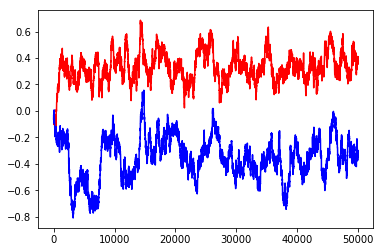

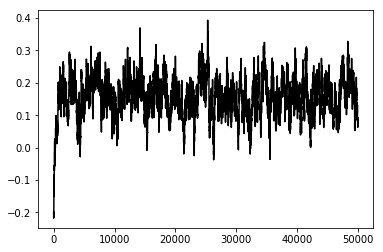

In [14]:
tm = 'Tottenham'
plot.plot(est[:, (1 + np.where(teams == tm)[0][0]).astype(int)], 'r')
plot.plot(est[:, (len(teams) + 1 + np.where(teams == tm)[0][0]).astype(int)], 'b')
plot.show()

plot.plot(est[:, 0], 'k')
plot.show()

In [32]:
# save parameters
burn = int((4 * niter) / 5)
mu_mean = np.array([np.mean(est[burn:, 0])])
mu_sd = np.array([np.std(est[burn:, 0])])
a_mean = np.mean(est[burn:, 1:(len(teams) + 1)], axis=0)
a_sd = np.std(est[burn:, 1:(len(teams) + 1)], axis=0)
d_mean = np.mean(est[burn:, (len(teams) + 1):((2 * len(teams)) + 1)], axis=0)
d_sd = np.std(est[burn:, (len(teams) + 1):((2 * len(teams)) + 1)], axis=0)
alpha_mean = np.array([np.mean(est[burn:, ((2 * len(teams)) + 1)])])
alpha_sd = np.array([np.std(est[burn:, ((2 * len(teams)) + 1)])])
means = np.concatenate((mu_mean, a_mean, d_mean, alpha_mean))
sds = np.concatenate((mu_sd, a_sd, d_sd, alpha_sd))

sds[1 + inds] = 0.1
sds[1 + len(teams) + inds] = 0.1

with open('all_teams.csv', mode='w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file, delimiter=',')
    for tm in teams:
        csv_writer.writerow([tm])
csv_file.close()

with open('all_teams_params.csv', mode='w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file, delimiter=',')
    for i in range(((2 * len(teams)) + 2)):
        csv_writer.writerow([means[i], sds[i]])
csv_file.close()

#### Save parameters here, and either predict for whole next season or individual gameweeks

In [16]:
# create fixture list this season to predict
fixture_list_this_season = []
for i, fix in enumerate(list(itertools.permutations(((pd.read_csv("teams_20192020.csv", header=None)).as_matrix())[:, 0], 2))):
    fixture_list_this_season.append(list(fix))
fixture_list_this_season = np.array(fixture_list_this_season)

c:\users\alsgregory\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


#### Update with week-by-week results 

In [17]:
# pre-requisits: read 'teams', and function import_fixture_list

In [18]:
# read this weeks results
fixture_list_this_week = import_fixture_list("prem_results_20182019.csv")
fixture_list_this_week = fixture_list_this_week.loc[:10, :]

In [20]:
# read params
all_teams_params = pd.read_csv("all_teams_params.csv", header=None)

# particles
N = 1000
tp = all_teams_params.as_matrix()
params = np.zeros((np.shape(tp)[0], N))
for j in range(np.shape(tp)[0]):
    params[j, :] = np.random.normal(tp[j, 0], tp[j, 1], N)

c:\users\alsgregory\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [21]:
# particle filter likelihood
xi = np.zeros(N)
for i in range(N):
    for j in range(len(fixture_list_this_week.index)):
        a_ht = params[1 + np.where(teams == fixture_list_this_week.loc[fixture_list_this_week.index[j], 0])[0], i]
        a_at = params[1 + np.where(teams == fixture_list_this_week.loc[fixture_list_this_week.index[j], 1])[0], i]
        d_ht = params[1 + len(teams) + np.where(teams == fixture_list_this_week.loc[fixture_list_this_week.index[j], 0])[0], i]
        d_at = params[1 + len(teams) + np.where(teams == fixture_list_this_week.loc[fixture_list_this_week.index[j], 1])[0], i]
        xi[i] += np.log(likelihood_one_game(fixture_list_this_week.loc[fixture_list_this_week.index[j], 2],
                                            fixture_list_this_week.loc[fixture_list_this_week.index[j], 3],
                                            5, 5, params[0, i], a_ht, d_ht, a_at, d_at, params[-1, i]))

In [25]:
resampled = np.random.choice(np.linspace(0, N - 1, N), N, p=np.exp(xi) / np.sum(np.exp(xi)))

In [26]:
resampled_params = params[:, resampled.astype(int)]

In [27]:
new_means = np.mean(resampled_params, axis=1)
new_sds = np.std(resampled_params, axis=1)

In [ ]:
#with open('all_teams_params.csv', mode='w', newline='') as csv_file:
#    csv_writer = csv.writer(csv_file, delimiter=',')
#    for i in range(((2 * len(teams)) + 2)):
#        csv_writer.writerow([new_means[i], new_sds[i]])
#csv_file.close()

#### Simulate seasons performance

In [28]:
wins = np.zeros(20)
topfour = np.zeros(20)
niter = 1000

# predict lambdas - average form
muest = np.hstack((means[0], sds[0]))
aest = np.hstack((np.reshape(means[1:(1+len(teams))], ((len(teams), 1))),
                  np.reshape(sds[1:(1+len(teams))], ((len(teams), 1)))))
dest = np.hstack((np.reshape(means[(1+len(teams)):(1+(2*len(teams)))], ((len(teams), 1))),
                  np.reshape(sds[(1+len(teams)):(1+(2*len(teams)))], ((len(teams), 1)))))
alphaest = np.hstack((means[((2 * len(teams)) + 1)], sds[((2 * len(teams)) + 1)]))

for j in range(niter):
    # work out total goals predicted
    total_goals = np.zeros(20)
    #actual_goals = np.zeros(20)
    total_goals_conceded = np.zeros(20)
    #actual_goals_conceded = np.zeros(20)
    tms = np.unique(fixture_list_this_season[:, 0])
    goals_this_season = predict_fixtures(fixture_list_this_season, np.ones((380, 2)) * 5, teams, muest, aest, dest, alphaest, uncertainty=True)
    pnts = np.zeros(20)
    for i in range(np.shape(fixture_list_this_season)[0]):
        goals_ht = np.random.poisson(goals_this_season[0][i])
        goals_at = np.random.poisson(goals_this_season[1][i])
        total_goals[np.where(tms == fixture_list_this_season[i, 0])[0][0].astype(int)] += goals_ht
        total_goals[np.where(tms == fixture_list_this_season[i, 1])[0][0].astype(int)] += goals_at
        pnts[np.where(tms == fixture_list_this_season[i, 0])[0][0].astype(int)] += ((goals_at < goals_ht) * 3) + (goals_at == goals_ht)
        pnts[np.where(tms == fixture_list_this_season[i, 1])[0][0].astype(int)] += ((goals_at > goals_ht) * 3) + (goals_at == goals_ht)
        #actual_goals[np.where(tms == fl2[i, 0])[0][0].astype(int)] += fl2[i, 2]
        #actual_goals[np.where(tms == fl2[i, 1])[0][0].astype(int)] += fl2[i, 3]
        total_goals_conceded[np.where(tms == fixture_list_this_season[i, 0])[0][0].astype(int)] += goals_at
        total_goals_conceded[np.where(tms == fixture_list_this_season[i, 1])[0][0].astype(int)] += goals_ht
        #actual_goals_conceded[np.where(tms == fl2[i, 0])[0][0].astype(int)] += fl2[i, 3]
        #actual_goals_conceded[np.where(tms == fl2[i, 1])[0][0].astype(int)] += fl2[i, 2]
    # update title wins
    wins[np.argmax(pnts)] += 1
    # update top four finishes
    topfour[np.argsort(pnts)[16:]] += 1

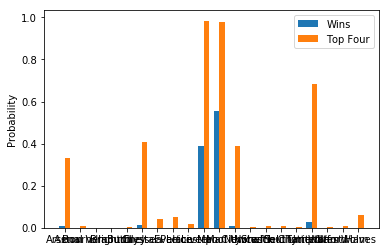

In [29]:
ind = np.arange(len(topfour))  # the x locations for the groups
width = 0.35  # the width of the bars

fig, ax = plot.subplots()
rects1 = ax.bar(ind - width/2, wins/niter, width,
                label='Wins')
rects2 = ax.bar(ind + width/2, topfour/niter, width,
                label='Top Four')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Probability')
ax.set_xticks(ind)
ax.set_xticklabels(tuple(tms))
ax.legend()

In [30]:
print(tms)
print(wins/niter)

['Arsenal' 'Aston Villa' 'Bournemouth' 'Brighton' 'Burnley' 'Chelsea'
 'Crystal Palace' 'Everton' 'Leicester' 'Liverpool' 'Man City'
 'Man United' 'Newcastle' 'Norwich City' 'Sheffield United' 'Southampton'
 'Tottenham' 'Watford' 'West Ham' 'Wolves']
[0.008 0.    0.    0.    0.    0.011 0.    0.001 0.    0.387 0.555 0.009
 0.    0.    0.    0.    0.028 0.    0.    0.001]


In [31]:
print(tms)
print(total_goals)
print(total_goals_conceded)
print(total_goals - total_goals_conceded)
print(np.argsort(pnts))

['Arsenal' 'Aston Villa' 'Bournemouth' 'Brighton' 'Burnley' 'Chelsea'
 'Crystal Palace' 'Everton' 'Leicester' 'Liverpool' 'Man City'
 'Man United' 'Newcastle' 'Norwich City' 'Sheffield United' 'Southampton'
 'Tottenham' 'Watford' 'West Ham' 'Wolves']
[63. 29. 40. 34. 44. 60. 43. 29. 59. 70. 71. 40. 27. 40. 50. 44. 59. 44.
 47. 40.]
[41. 57. 66. 56. 49. 33. 45. 37. 53. 23. 20. 56. 59. 47. 55. 50. 36. 58.
 44. 48.]
[ 22. -28. -26. -22.  -5.  27.  -2.  -8.   6.  47.  51. -16. -32.  -7.
  -5.  -6.  23. -14.   3.  -8.]
[ 1 12  2  7  3 11 13 15  6 17  8 19 18  4 14  5 16  0  9 10]
